# Comparison of ML model and OGGM, PYGEM, GLOGEM on point mass balance

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde

import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from helpers import get_ytrue_y_pred_agg
from helpers import get_ytrue_y_pred_agg_season
from helpers import get_prediction_per_season_test

from model_classes import CustomXGBRegressor

#from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_season


## Helper functions

In [2]:
# Get modelled mass balance from xarray Dataset based on 
# dataframe of point mass balances
def get_modelled_mb(df, ds, type):
    """
    df : pd.DataFrame of point mb (mass balance)
    ds : xr.DataSet of modelled mass balance
    type : str, variable in ds; 'mb_annual', 'mb_summer', or 'mb_winter'
    """
    
    mb_modelled = []

    # Loop through each row of df to extract modelled mb for the given ID, year, and nearest elevation
    for row in df.itertuples(index=False):

        # Use the attributes of namedtuple
        current_year = str(row.year) + '-10-01'
        current_altitude = row.altitude
        current_id = str(row.ID)
        current_year_dt = np.datetime64(current_year)

        # Check if the current_year_dt is in the 'time' coordinate of the dataset
        if current_year_dt in ds['time'].values:

            # Find nearest elevation to point
            nearest_elevation_idx = abs(ds['elevation'] - current_altitude).argmin()
            nearest_elevation = ds['elevation'][nearest_elevation_idx]

            # Check if current_id exists in the 'ID' coordinate of the dataset
            if current_id in ds['ID'].values:

                mb_val = ds[type].sel(
                    ID=current_id, time=current_year_dt, elevation=nearest_elevation).values

                mb_val = mb_val.item()
            else:
                mb_val = np.nan
        else:
            # If modelled mb is not available for the current year, use nan
            mb_val = np.nan

        mb_modelled.append(mb_val)

    return mb_modelled


## Plotting functions

In [3]:
# Plot modelled and observed point mass balances
def plot_point_modelled(df, model, start_yr, end_yr):

    """
    df : pd.Dataframe of point mb
    type : str, variable in ds; 'netto', 'summer' or 'winter'
    model : str, model name; 'glogem', 'oggm', 'pygem'
    """

    df_clean_dropna = df.dropna(subset=['mb_'+model])

    df_clean = df_clean_dropna[(df_clean_dropna['year'] >= start_yr) & (df_clean_dropna['year'] <= end_yr)]

    y_data = df_clean['mb_'+model]
    x_data = df_clean['balance']
    
    xy = np.vstack([x_data, y_data])
    z = gaussian_kde(xy)(xy)

    df_with_density = pd.DataFrame({
        'x': x_data,
        'y': y_data,
        'z': z
        })

    df_with_density.sort_values('z', inplace=True)

    fig, ax = plt.subplots()
    scatter = ax.scatter(df_with_density['x'], df_with_density['y'], c=df_with_density['z'], s=50, cmap='viridis')

    max_val = max(x_data.max(), y_data.max())+0.5
    min_val = min(x_data.min(), y_data.min())-0.5
    
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='1:1 Line')
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xlabel('mb stake (m w.e.)')
    ax.set_ylabel('mb modelled elev band (m w.e.)')
    plt.title('Stake vs. ' + model)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_data, x_data))
    mae = mean_absolute_error(y_data, x_data) 
    r2 = r2_score(y_data, x_data) 
    count = len(x_data)  # Count the number of data points
    
    stats_text = f'Count: {count}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
    
    #plt.legend()
    plt.colorbar(ax.collections[0], ax=ax, label='Density')
    plt.tight_layout()
    plt.grid(alpha=0.5)
    plt.show()


## Get test dataset of monthly values 

14 glaciers: [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]

- 54: 189 points
- 703: 30 points
- 941: 70 points
- 1135: 
- 1280: 71 points
- 2085: 
- 2320: 83 points
- 2478: 89 points
- 2768:
- 2769: 121 points
- 3133: 38 points
- 3137: 65 points
- 3138: 6 points
- 3141: 72 points

In [4]:
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_test_svf.csv'

# Load data.
df_test_final = pd.read_csv(filepath + filename, index_col=0)

In [5]:
df_test_final

id  BREID           RGIID  altitude  altitude_climate  year  \
0         0     54  RGI60-08.01258     471.0        341.227919  2013   
1         0     54  RGI60-08.01258     471.0        341.227919  2013   
2         0     54  RGI60-08.01258     471.0        341.227919  2013   
3         0     54  RGI60-08.01258     471.0        341.227919  2013   
4         0     54  RGI60-08.01258     471.0        341.227919  2013   
...     ...    ...             ...       ...               ...   ...   
24908  3091   3141  RGI60-08.02969    1078.0        917.419759  2017   
24909  3091   3141  RGI60-08.02969    1078.0        917.419759  2017   
24910  3091   3141  RGI60-08.02969    1078.0        917.419759  2017   
24911  3091   3141  RGI60-08.02969    1078.0        917.419759  2017   
24912  3091   3141  RGI60-08.02969    1078.0        917.419759  2017   

       altitude_diff  balance    aspect     slope  skyview_factor  n_months  \
0        -129.772081    -6.24  0.629597  0.278773        0.778997         5   
1        -129.772081    -6.24  0.629597  0.278773        0.778997         5   
2        -129.772081    -6.24  0.629597  0.278773        0.778997         5   
3        -129.772081    -6.24  0.629597  0.278773        0.778997         5   
4        -129.772081    -6.24  0.629597  0.278773        0.778997         5   
...              ...      ...       ...       ...             ...       ...   
24908    -160.580241    -3.29  2.906044  0.131717        0.932281        12   
24909    -160.580241    -3.29  2.906044  0.131717        0.932281        12   
24910    -160.580241    -3.29  2.906044  0.131717        0.932281        12   
24911    -160.580241    -3.29  2.906044  0.131717        0.932281        12   
24912    -160.580241    -3.29  2.906044  0.131717        0.932281        12   

      month         t2m          sshf       slhf        ssrd       fal  \
0       may  277.677979  4.286715e+05  -237874.5  20979516.0  0.580414   
1       jun  283.339630 -2.133166e+06 -4024573.5  17728592.0  0.198752   
2       jul  283.829285 -2.731458e+06 -5184939.5  15538729.0  0.131911   
3       aug  283.778412 -1.295387e+06 -3545874.5  10510849.0  0.130799   
4       sep  280.982513  9.352438e+03 -1756179.5   6908671.0  0.130148   
...     ...         ...           ...        ...         ...       ...   
24908   may  277.690887 -5.189375e+02   -71670.0  17926120.0  0.530146   
24909   jun  280.319031  1.046328e+05  -101796.5  13385372.0  0.480811   
24910   jul  282.416504 -2.174798e+06 -4535185.5  15446657.0  0.183955   
24911   aug  281.939026 -1.997971e+06 -3884410.5  11212546.0  0.135438   
24912   sep  280.775269 -9.919489e+05 -2517502.0   7614423.5  0.133470   

              str        tp  
0     -3367191.50  0.001159  
1     -3994740.00  0.003054  
2     -4661453.00  0.003977  
3     -4018348.50  0.004691  
4     -4441106.50  0.001449  
...           ...       ...  
24908 -2093793.25  0.003567  
24909   162197.00  0.008162  
24910 -3726261.25  0.007537  
24911 -3417520.00  0.007390  
24912 -3192232.00  0.006440  

[24913 rows x 20 columns]

In [6]:
# Add column for short form RGIID for retreival of model results
df_test_final['ID'] = df_test_final['RGIID'].str[-4:] # Short form of RGIID

In [7]:
df_test_final.ID = df_test_final.ID.astype(int)
df_test_final

id  BREID           RGIID  altitude  altitude_climate  year  \
0         0     54  RGI60-08.01258     471.0        341.227919  2013   
1         0     54  RGI60-08.01258     471.0        341.227919  2013   
2         0     54  RGI60-08.01258     471.0        341.227919  2013   
3         0     54  RGI60-08.01258     471.0        341.227919  2013   
4         0     54  RGI60-08.01258     471.0        341.227919  2013   
...     ...    ...             ...       ...               ...   ...   
24908  3091   3141  RGI60-08.02969    1078.0        917.419759  2017   
24909  3091   3141  RGI60-08.02969    1078.0        917.419759  2017   
24910  3091   3141  RGI60-08.02969    1078.0        917.419759  2017   
24911  3091   3141  RGI60-08.02969    1078.0        917.419759  2017   
24912  3091   3141  RGI60-08.02969    1078.0        917.419759  2017   

       altitude_diff  balance    aspect     slope  ...  n_months  month  \
0        -129.772081    -6.24  0.629597  0.278773  ...         5    may   
1        -129.772081    -6.24  0.629597  0.278773  ...         5    jun   
2        -129.772081    -6.24  0.629597  0.278773  ...         5    jul   
3        -129.772081    -6.24  0.629597  0.278773  ...         5    aug   
4        -129.772081    -6.24  0.629597  0.278773  ...         5    sep   
...              ...      ...       ...       ...  ...       ...    ...   
24908    -160.580241    -3.29  2.906044  0.131717  ...        12    may   
24909    -160.580241    -3.29  2.906044  0.131717  ...        12    jun   
24910    -160.580241    -3.29  2.906044  0.131717  ...        12    jul   
24911    -160.580241    -3.29  2.906044  0.131717  ...        12    aug   
24912    -160.580241    -3.29  2.906044  0.131717  ...        12    sep   

              t2m          sshf       slhf        ssrd       fal         str  \
0      277.677979  4.286715e+05  -237874.5  20979516.0  0.580414 -3367191.50   
1      283.339630 -2.133166e+06 -4024573.5  17728592.0  0.198752 -3994740.00   
2      283.829285 -2.731458e+06 -5184939.5  15538729.0  0.131911 -4661453.00   
3      283.778412 -1.295387e+06 -3545874.5  10510849.0  0.130799 -4018348.50   
4      280.982513  9.352438e+03 -1756179.5   6908671.0  0.130148 -4441106.50   
...           ...           ...        ...         ...       ...         ...   
24908  277.690887 -5.189375e+02   -71670.0  17926120.0  0.530146 -2093793.25   
24909  280.319031  1.046328e+05  -101796.5  13385372.0  0.480811   162197.00   
24910  282.416504 -2.174798e+06 -4535185.5  15446657.0  0.183955 -3726261.25   
24911  281.939026 -1.997971e+06 -3884410.5  11212546.0  0.135438 -3417520.00   
24912  280.775269 -9.919489e+05 -2517502.0   7614423.5  0.133470 -3192232.00   

             tp    ID  
0      0.001159  1258  
1      0.003054  1258  
2      0.003977  1258  
3      0.004691  1258  
4      0.001449  1258  
...         ...   ...  
24908  0.003567  2969  
24909  0.008162  2969  
24910  0.007537  2969  
24911  0.007390  2969  
24912  0.006440  2969  

[24913 rows x 21 columns]

### Get targets and features for ML model

In [8]:
# Select features for test
df_test_X_reduce = df_test_final.drop(['balance','year','BREID','RGIID', 'ID','altitude','altitude_climate'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_test_X = df_test_X_reduce[[c for c in df_test_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for test
df_test_y = df_test_final[['balance']]

# Get arrays of features+metadata and targets
X_test, y_test = df_test_X.values, df_test_y.values

In [9]:
df_test_X_reduce

id  altitude_diff    aspect     slope  skyview_factor  n_months  \
0         0    -129.772081  0.629597  0.278773        0.778997         5   
1         0    -129.772081  0.629597  0.278773        0.778997         5   
2         0    -129.772081  0.629597  0.278773        0.778997         5   
3         0    -129.772081  0.629597  0.278773        0.778997         5   
4         0    -129.772081  0.629597  0.278773        0.778997         5   
...     ...            ...       ...       ...             ...       ...   
24908  3091    -160.580241  2.906044  0.131717        0.932281        12   
24909  3091    -160.580241  2.906044  0.131717        0.932281        12   
24910  3091    -160.580241  2.906044  0.131717        0.932281        12   
24911  3091    -160.580241  2.906044  0.131717        0.932281        12   
24912  3091    -160.580241  2.906044  0.131717        0.932281        12   

      month         t2m          sshf       slhf        ssrd       fal  \
0       may  277.677979  4.286715e+05  -237874.5  20979516.0  0.580414   
1       jun  283.339630 -2.133166e+06 -4024573.5  17728592.0  0.198752   
2       jul  283.829285 -2.731458e+06 -5184939.5  15538729.0  0.131911   
3       aug  283.778412 -1.295387e+06 -3545874.5  10510849.0  0.130799   
4       sep  280.982513  9.352438e+03 -1756179.5   6908671.0  0.130148   
...     ...         ...           ...        ...         ...       ...   
24908   may  277.690887 -5.189375e+02   -71670.0  17926120.0  0.530146   
24909   jun  280.319031  1.046328e+05  -101796.5  13385372.0  0.480811   
24910   jul  282.416504 -2.174798e+06 -4535185.5  15446657.0  0.183955   
24911   aug  281.939026 -1.997971e+06 -3884410.5  11212546.0  0.135438   
24912   sep  280.775269 -9.919489e+05 -2517502.0   7614423.5  0.133470   

              str        tp  
0     -3367191.50  0.001159  
1     -3994740.00  0.003054  
2     -4661453.00  0.003977  
3     -4018348.50  0.004691  
4     -4441106.50  0.001449  
...           ...       ...  
24908 -2093793.25  0.003567  
24909   162197.00  0.008162  
24910 -3726261.25  0.007537  
24911 -3417520.00  0.007390  
24912 -3192232.00  0.006440  

[24913 rows x 14 columns]

### Get dataframes of annual, summer and winter mass balances for comparison

In [10]:
df_test_final

id  BREID           RGIID  altitude  altitude_climate  year  \
0         0     54  RGI60-08.01258     471.0        341.227919  2013   
1         0     54  RGI60-08.01258     471.0        341.227919  2013   
2         0     54  RGI60-08.01258     471.0        341.227919  2013   
3         0     54  RGI60-08.01258     471.0        341.227919  2013   
4         0     54  RGI60-08.01258     471.0        341.227919  2013   
...     ...    ...             ...       ...               ...   ...   
24908  3091   3141  RGI60-08.02969    1078.0        917.419759  2017   
24909  3091   3141  RGI60-08.02969    1078.0        917.419759  2017   
24910  3091   3141  RGI60-08.02969    1078.0        917.419759  2017   
24911  3091   3141  RGI60-08.02969    1078.0        917.419759  2017   
24912  3091   3141  RGI60-08.02969    1078.0        917.419759  2017   

       altitude_diff  balance    aspect     slope  ...  n_months  month  \
0        -129.772081    -6.24  0.629597  0.278773  ...         5    may   
1        -129.772081    -6.24  0.629597  0.278773  ...         5    jun   
2        -129.772081    -6.24  0.629597  0.278773  ...         5    jul   
3        -129.772081    -6.24  0.629597  0.278773  ...         5    aug   
4        -129.772081    -6.24  0.629597  0.278773  ...         5    sep   
...              ...      ...       ...       ...  ...       ...    ...   
24908    -160.580241    -3.29  2.906044  0.131717  ...        12    may   
24909    -160.580241    -3.29  2.906044  0.131717  ...        12    jun   
24910    -160.580241    -3.29  2.906044  0.131717  ...        12    jul   
24911    -160.580241    -3.29  2.906044  0.131717  ...        12    aug   
24912    -160.580241    -3.29  2.906044  0.131717  ...        12    sep   

              t2m          sshf       slhf        ssrd       fal         str  \
0      277.677979  4.286715e+05  -237874.5  20979516.0  0.580414 -3367191.50   
1      283.339630 -2.133166e+06 -4024573.5  17728592.0  0.198752 -3994740.00   
2      283.829285 -2.731458e+06 -5184939.5  15538729.0  0.131911 -4661453.00   
3      283.778412 -1.295387e+06 -3545874.5  10510849.0  0.130799 -4018348.50   
4      280.982513  9.352438e+03 -1756179.5   6908671.0  0.130148 -4441106.50   
...           ...           ...        ...         ...       ...         ...   
24908  277.690887 -5.189375e+02   -71670.0  17926120.0  0.530146 -2093793.25   
24909  280.319031  1.046328e+05  -101796.5  13385372.0  0.480811   162197.00   
24910  282.416504 -2.174798e+06 -4535185.5  15446657.0  0.183955 -3726261.25   
24911  281.939026 -1.997971e+06 -3884410.5  11212546.0  0.135438 -3417520.00   
24912  280.775269 -9.919489e+05 -2517502.0   7614423.5  0.133470 -3192232.00   

             tp    ID  
0      0.001159  1258  
1      0.003054  1258  
2      0.003977  1258  
3      0.004691  1258  
4      0.001449  1258  
...         ...   ...  
24908  0.003567  2969  
24909  0.008162  2969  
24910  0.007537  2969  
24911  0.007390  2969  
24912  0.006440  2969  

[24913 rows x 21 columns]

In [11]:
df_test_annual = df_test_final[df_test_final['n_months']==12]
df_test_annual = df_test_annual.groupby(by=['id']).mean() 
df_test_annual

C:\Users\kasj\AppData\Local\Temp\ipykernel_23956\4077999050.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_annual = df_test_annual.groupby(by=['id']).mean()


BREID  altitude  altitude_climate    year  altitude_diff  balance  \
id                                                                         
2027    54.0     471.0        341.227919  2013.0    -129.772081    -4.92   
2028    54.0     439.0        341.227919  2014.0     -97.772081    -2.67   
2029    54.0     444.0        341.227919  2015.0    -102.772081    -3.41   
2030    54.0     444.0        341.227919  2016.0    -102.772081    -3.59   
2031    54.0     468.0        341.227919  2017.0    -126.772081    -2.46   
...      ...       ...               ...     ...            ...      ...   
3087  3141.0    1078.0        917.419759  2012.0    -160.580241    -2.07   
3088  3141.0    1078.0        917.419759  2013.0    -160.580241    -3.15   
3089  3141.0    1079.0        917.419759  2015.0    -161.580241    -2.61   
3090  3141.0    1078.0        917.419759  2016.0    -160.580241    -2.66   
3091  3141.0    1078.0        917.419759  2017.0    -160.580241    -3.29   

        aspect     slope  skyview_factor  n_months         t2m           sshf  \
id                                                                              
2027  0.629597  0.278773        0.778997      12.0  273.045766  -10104.210938   
2028  0.585924  0.296590        0.798494      12.0  272.938726  225771.765625   
2029  0.663261  0.302508        0.803510      12.0  272.849403  133388.494792   
2030  0.663261  0.302508        0.803510      12.0  273.300074  -14896.781250   
2031  0.836757  0.309196        0.817480      12.0  272.918989  279420.552083   
...        ...       ...             ...       ...         ...            ...   
3087  2.906044  0.131717        0.932281      12.0  274.500407 -340938.494792   
3088  2.906044  0.131717        0.932281      12.0  272.949669 -419158.447917   
3089  2.906044  0.131717        0.932281      12.0  274.638379 -144798.453125   
3090  2.906044  0.131717        0.932281      12.0  275.167430 -404816.317708   
3091  2.906044  0.131717        0.932281      12.0  274.879850 -432534.911458   

              slhf          ssrd       fal           str        tp      ID  
id                                                                          
2027 -1.192698e+06  8.000492e+06  0.534814 -2.960371e+06  0.003176  1258.0  
2028 -8.952235e+05  7.755540e+06  0.585304 -2.756938e+06  0.003372  1258.0  
2029 -9.804107e+05  7.343682e+06  0.556681 -2.772570e+06  0.003141  1258.0  
2030 -1.064662e+06  7.145984e+06  0.540813 -2.628417e+06  0.003110  1258.0  
2031 -7.474015e+05  7.817598e+06  0.538918 -2.767568e+06  0.003548  1258.0  
...            ...           ...       ...           ...       ...     ...  
3087 -8.186743e+05  8.780470e+06  0.547067 -2.065823e+06  0.008703  2969.0  
3088 -1.114851e+06  9.078827e+06  0.541262 -2.491021e+06  0.006297  2969.0  
3089 -6.082808e+05  8.741161e+06  0.560521 -1.893852e+06  0.009249  2969.0  
3090 -1.068619e+06  8.679002e+06  0.501434 -2.248240e+06  0.008690  2969.0  
3091 -1.075172e+06  8.313585e+06  0.515644 -2.167410e+06  0.007674  2969.0  

[1065 rows x 18 columns]

In [12]:
df_test_winter = df_test_final[df_test_final['n_months']==7]
df_test_winter = df_test_winter.groupby(by=['id']).mean() 
df_test_winter

C:\Users\kasj\AppData\Local\Temp\ipykernel_23956\3206729110.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_winter = df_test_winter.groupby(by=['id']).mean()


BREID  altitude  altitude_climate    year  altitude_diff  balance  \
id                                                                         
1028    54.0     471.0        341.227919  2013.0    -129.772081     1.32   
1029    54.0     439.0        341.227919  2014.0     -97.772081     1.68   
1030    54.0     444.0        341.227919  2015.0    -102.772081     0.76   
1031    54.0     444.0        341.227919  2016.0    -102.772081     0.78   
1032    54.0     468.0        341.227919  2017.0    -126.772081     1.59   
...      ...       ...               ...     ...            ...      ...   
2022  3141.0    1078.0        917.419759  2012.0    -160.580241     1.50   
2023  3141.0    1078.0        917.419759  2013.0    -160.580241     1.14   
2024  3141.0    1079.0        917.419759  2015.0    -161.580241     1.19   
2025  3141.0    1078.0        917.419759  2016.0    -160.580241     1.72   
2026  3141.0    1078.0        917.419759  2017.0    -160.580241     1.15   

        aspect     slope  skyview_factor  n_months         t2m           sshf  \
id                                                                              
1028  0.629597  0.278773        0.778997       7.0  266.705911  800105.232143   
1029  0.585924  0.296590        0.798494       7.0  267.740727  996367.901786   
1030  0.663261  0.302508        0.803510       7.0  267.579795  946459.196429   
1031  0.663261  0.302508        0.803510       7.0  267.811977  868039.937500   
1032  0.836757  0.309196        0.817480       7.0  268.226903  856574.433036   
...        ...       ...             ...       ...         ...            ...   
2022  2.906044  0.131717        0.932281       7.0  270.836827   23270.491071   
2023  2.906044  0.131717        0.932281       7.0  267.233730  125356.500000   
2024  2.906044  0.131717        0.932281       7.0  271.190260   -7447.285714   
2025  2.906044  0.131717        0.932281       7.0  270.403787   18733.339286   
2026  2.906044  0.131717        0.932281       7.0  270.773926  -18544.928571   

               slhf          ssrd       fal           str        tp      ID  
id                                                                           
1028   62438.500000  3.477078e+06  0.749392 -2.148801e+06  0.003397  1258.0  
1029   65465.714286  3.052352e+06  0.758143 -2.145037e+06  0.003847  1258.0  
1030   21334.214286  3.186665e+06  0.750785 -2.258321e+06  0.002979  1258.0  
1031  102229.642857  3.540237e+06  0.771447 -2.084224e+06  0.003243  1258.0  
1032   64772.571429  3.494867e+06  0.679859 -2.391737e+06  0.003806  1258.0  
...             ...           ...       ...           ...       ...     ...  
2022 -171713.642857  4.804682e+06  0.683440 -1.769234e+06  0.010046  2969.0  
2023 -123023.142857  5.492646e+06  0.711911 -2.165743e+06  0.006262  2969.0  
2024 -271647.642857  4.664342e+06  0.653273 -1.837262e+06  0.011195  2969.0  
2025 -251040.928571  5.058185e+06  0.655849 -1.987646e+06  0.009280  2969.0  
2026 -255928.142857  4.882558e+06  0.674844 -1.963044e+06  0.008427  2969.0  

[999 rows x 18 columns]

In [13]:
df_test_summer = df_test_final[df_test_final['n_months']==5]
df_test_summer = df_test_summer.groupby(by=['id']).mean() 
df_test_summer

C:\Users\kasj\AppData\Local\Temp\ipykernel_23956\1147432955.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_test_summer = df_test_summer.groupby(by=['id']).mean()


BREID  altitude  altitude_climate    year  altitude_diff  balance  \
id                                                                         
0       54.0     471.0        341.227919  2013.0    -129.772081    -6.24   
1       54.0     439.0        341.227919  2014.0     -97.772081    -4.35   
2       54.0     444.0        341.227919  2015.0    -102.772081    -4.17   
3       54.0     444.0        341.227919  2016.0    -102.772081    -4.37   
4       54.0     468.0        341.227919  2017.0    -126.772081    -4.05   
...      ...       ...               ...     ...            ...      ...   
1023  3141.0    1078.0        917.419759  2012.0    -160.580241    -3.57   
1024  3141.0    1078.0        917.419759  2013.0    -160.580241    -4.29   
1025  3141.0    1079.0        917.419759  2015.0    -161.580241    -3.80   
1026  3141.0    1078.0        917.419759  2016.0    -160.580241    -4.38   
1027  3141.0    1078.0        917.419759  2017.0    -160.580241    -4.44   

        aspect     slope  skyview_factor  n_months         t2m          sshf  \
id                                                                             
0     0.629597  0.278773        0.778997       5.0  281.921564 -1.144397e+06   
1     0.585924  0.296590        0.798494       5.0  280.215924 -8.530628e+05   
2     0.663261  0.302508        0.803510       5.0  280.226855 -1.004910e+06   
3     0.663261  0.302508        0.803510       5.0  280.983411 -1.251008e+06   
4     0.836757  0.309196        0.817480       5.0  279.487909 -5.285949e+05   
...        ...       ...             ...       ...         ...           ...   
1023  2.906044  0.131717        0.932281       5.0  279.629419 -8.508311e+05   
1024  2.906044  0.131717        0.932281       5.0  280.951984 -1.181479e+06   
1025  2.906044  0.131717        0.932281       5.0  279.465747 -3.370901e+05   
1026  2.906044  0.131717        0.932281       5.0  281.836530 -9.977858e+05   
1027  2.906044  0.131717        0.932281       5.0  280.628143 -1.012121e+06   

            slhf        ssrd       fal         str        tp      ID  
id                                                                    
0    -2949888.30  14333271.4  0.234405 -4096567.90  0.002866  1258.0  
1    -2240188.45  14340004.3  0.343329 -3613599.05  0.002707  1258.0  
2    -2382853.60  13163506.1  0.284936 -3492518.15  0.003367  1258.0  
3    -2698309.70  12194028.9  0.217927 -3390287.60  0.002925  1258.0  
4    -1884445.15  13869421.1  0.341601 -3293730.55  0.003186  1258.0  
...          ...         ...       ...         ...       ...     ...  
1023 -1724419.25  14346574.6  0.356145 -2481046.90  0.006822  2969.0  
1024 -2503409.00  14099480.7  0.302352 -2946410.05  0.006346  2969.0  
1025 -1079567.30  14448706.6  0.430668 -1973078.45  0.006524  2969.0  
1026 -2213228.25  13748145.0  0.285253 -2613071.80  0.007863  2969.0  
1027 -2222112.90  13117023.7  0.292764 -2453521.90  0.006619  2969.0  

[1028 rows x 18 columns]

In [14]:
df_test_annual.reset_index(drop=True, inplace=True)
df_test_winter.reset_index(drop=True, inplace=True)
df_test_summer.reset_index(drop=True, inplace=True)

df_test_annual.ID = df_test_annual.ID.astype(np.int64)
df_test_winter.ID = df_test_winter.ID.astype(np.int64)
df_test_summer.ID = df_test_summer.ID.astype(np.int64)
df_test_annual['ID'] = df_test_annual['ID'].astype(str).str.zfill(4).str[-4:]
df_test_winter['ID'] = df_test_winter['ID'].astype(str).str.zfill(4).str[-4:]
df_test_summer['ID'] = df_test_summer['ID'].astype(str).str.zfill(4).str[-4:]

df_test_annual.year = df_test_annual.year.astype(np.int64)
df_test_winter.year = df_test_winter.year.astype(np.int64)
df_test_summer.year = df_test_summer.year.astype(np.int64)

In [15]:
print(df_test_annual.dtypes)


BREID               float64
altitude            float64
altitude_climate    float64
year                  int64
altitude_diff       float64
balance             float64
aspect              float64
slope               float64
skyview_factor      float64
n_months            float64
t2m                 float64
sshf                float64
slhf                float64
ssrd                float64
fal                 float64
str                 float64
tp                  float64
ID                   object
dtype: object


## Get TI-model predictions

In [16]:
# Get mass balance predictions for OGGM, PYGEM, GLOGEM
filepath_models = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

fn_glogem_ann_seas_elev_band = 'GloGEM_annual_seasonal_mb_elev_band.nc'
fn_oggm_ann_seas_elev_band = 'OGGM_annual_seasonal_mb_elev_band.nc'
fn_pygem_ann_seas_elev_band = 'PyGEM_annual_seasonal_mb_elev_band.nc'

with xr.open_dataset(filepath_models + fn_glogem_ann_seas_elev_band) as ds_glogem:
    ds_glogem_ann_seas_elev_band = ds_glogem

with xr.open_dataset(filepath_models + fn_oggm_ann_seas_elev_band) as ds_oggm:
    ds_oggm_ann_seas_elev_band = ds_oggm

with xr.open_dataset(filepath_models + fn_pygem_ann_seas_elev_band) as ds_pygem:
    ds_pygem_ann_seas_elev_band = ds_pygem


In [17]:
ds_glogem_ann_seas_elev_band

<xarray.Dataset>
Dimensions:    (time: 40, elevation: 225, ID: 32)
Coordinates:
  * time       (time) datetime64[ns] 1980-10-01 1981-10-01 ... 2019-10-01
  * elevation  (elevation) int64 145 155 165 175 185 ... 2355 2365 2375 2385
  * ID         (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 ...
    mb_winter  (ID, time, elevation) float64 ...
    mb_summer  (ID, time, elevation) float64 ...
Attributes:
    Model:    GloGEM

In [18]:
ds_pygem_ann_seas_elev_band

<xarray.Dataset>
Dimensions:    (elevation: 226, time: 62, ID: 32)
Coordinates:
  * elevation  (elevation) float64 85.0 95.0 105.0 ... 2.325e+03 2.335e+03
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2022-10-01
  * ID         (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 ...
    mb_winter  (ID, time, elevation) float64 ...
    mb_summer  (ID, time, elevation) float64 ...
Attributes:
    Model:    PyGEM

In [19]:
ds_oggm_ann_seas_elev_band


<xarray.Dataset>
Dimensions:    (time: 59, elevation: 237, ID: 32)
Coordinates:
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2019-10-01
  * elevation  (elevation) int64 25 35 45 55 65 75 ... 2345 2355 2365 2375 2385
  * ID         (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 ...
    mb_winter  (ID, time, elevation) float64 ...
    mb_summer  (ID, time, elevation) float64 ...
Attributes:
    Model:    OGGM

In [20]:
# All data, not only test

#glacier_data_annual['mb_glogem'] = get_modelled_mb(glacier_data_annual, ds_glogem_ann_seas_elev_band, 'mb_annual')
#glacier_data_annual['mb_pygem'] = get_modelled_mb(glacier_data_annual, ds_pygem_ann_seas_elev_band, 'mb_annual')
#glacier_data_annual['mb_oggm'] = get_modelled_mb(glacier_data_annual, ds_oggm_ann_seas_elev_band, 'mb_annual')

#glacier_data_winter['mb_glogem'] = get_modelled_mb(glacier_data_winter, ds_glogem_ann_seas_elev_band, 'mb_winter')
#glacier_data_winter['mb_pygem'] = get_modelled_mb(glacier_data_winter, ds_pygem_ann_seas_elev_band, 'mb_winter')
#glacier_data_winter['mb_oggm'] = get_modelled_mb(glacier_data_winter, ds_oggm_ann_seas_elev_band, 'mb_winter')

#glacier_data_summer['mb_glogem'] = get_modelled_mb(glacier_data_summer, ds_glogem_ann_seas_elev_band, 'mb_summer')
#glacier_data_summer['mb_pygem'] = get_modelled_mb(glacier_data_summer, ds_pygem_ann_seas_elev_band, 'mb_summer')
#glacier_data_summer['mb_oggm'] = get_modelled_mb(glacier_data_summer, ds_oggm_ann_seas_elev_band, 'mb_summer')


In [21]:
# Get modelled annual, winter and summer mass balance for test points
df_test_annual['mb_glogem'] = get_modelled_mb(df_test_annual, ds_glogem_ann_seas_elev_band, 'mb_annual')
df_test_annual['mb_oggm'] = get_modelled_mb(df_test_annual, ds_oggm_ann_seas_elev_band, 'mb_annual')
df_test_annual['mb_pygem'] = get_modelled_mb(df_test_annual, ds_pygem_ann_seas_elev_band, 'mb_annual')

In [22]:
df_test_annual

BREID  altitude  altitude_climate  year  altitude_diff  balance  \
0       54.0     471.0        341.227919  2013    -129.772081    -4.92   
1       54.0     439.0        341.227919  2014     -97.772081    -2.67   
2       54.0     444.0        341.227919  2015    -102.772081    -3.41   
3       54.0     444.0        341.227919  2016    -102.772081    -3.59   
4       54.0     468.0        341.227919  2017    -126.772081    -2.46   
...      ...       ...               ...   ...            ...      ...   
1060  3141.0    1078.0        917.419759  2012    -160.580241    -2.07   
1061  3141.0    1078.0        917.419759  2013    -160.580241    -3.15   
1062  3141.0    1079.0        917.419759  2015    -161.580241    -2.61   
1063  3141.0    1078.0        917.419759  2016    -160.580241    -2.66   
1064  3141.0    1078.0        917.419759  2017    -160.580241    -3.29   

        aspect     slope  skyview_factor  n_months  ...           sshf  \
0     0.629597  0.278773        0.778997      12.0  ...  -10104.210938   
1     0.585924  0.296590        0.798494      12.0  ...  225771.765625   
2     0.663261  0.302508        0.803510      12.0  ...  133388.494792   
3     0.663261  0.302508        0.803510      12.0  ...  -14896.781250   
4     0.836757  0.309196        0.817480      12.0  ...  279420.552083   
...        ...       ...             ...       ...  ...            ...   
1060  2.906044  0.131717        0.932281      12.0  ... -340938.494792   
1061  2.906044  0.131717        0.932281      12.0  ... -419158.447917   
1062  2.906044  0.131717        0.932281      12.0  ... -144798.453125   
1063  2.906044  0.131717        0.932281      12.0  ... -404816.317708   
1064  2.906044  0.131717        0.932281      12.0  ... -432534.911458   

              slhf          ssrd       fal           str        tp    ID  \
0    -1.192698e+06  8.000492e+06  0.534814 -2.960371e+06  0.003176  1258   
1    -8.952235e+05  7.755540e+06  0.585304 -2.756938e+06  0.003372  1258   
2    -9.804107e+05  7.343682e+06  0.556681 -2.772570e+06  0.003141  1258   
3    -1.064662e+06  7.145984e+06  0.540813 -2.628417e+06  0.003110  1258   
4    -7.474015e+05  7.817598e+06  0.538918 -2.767568e+06  0.003548  1258   
...            ...           ...       ...           ...       ...   ...   
1060 -8.186743e+05  8.780470e+06  0.547067 -2.065823e+06  0.008703  2969   
1061 -1.114851e+06  9.078827e+06  0.541262 -2.491021e+06  0.006297  2969   
1062 -6.082808e+05  8.741161e+06  0.560521 -1.893852e+06  0.009249  2969   
1063 -1.068619e+06  8.679002e+06  0.501434 -2.248240e+06  0.008690  2969   
1064 -1.075172e+06  8.313585e+06  0.515644 -2.167410e+06  0.007674  2969   

     mb_glogem   mb_oggm  mb_pygem  
0       -4.285 -4.103744 -4.519159  
1          NaN -2.959274       NaN  
2       -3.809 -2.939396       NaN  
3       -4.202 -3.638283       NaN  
4       -2.209 -2.350578       NaN  
...        ...       ...       ...  
1060    -1.602 -1.856753       NaN  
1061    -3.323 -3.670277       NaN  
1062    -0.723 -1.706005       NaN  
1063    -2.512 -3.103452       NaN  
1064    -2.022 -2.971997       NaN  

[1065 rows x 21 columns]

In [23]:
df_test_winter['mb_glogem'] = get_modelled_mb(df_test_winter, ds_glogem_ann_seas_elev_band, 'mb_winter')
df_test_winter['mb_oggm'] = get_modelled_mb(df_test_winter, ds_oggm_ann_seas_elev_band, 'mb_winter')
df_test_winter['mb_pygem'] = get_modelled_mb(df_test_winter, ds_pygem_ann_seas_elev_band, 'mb_winter')

In [24]:
df_test_winter

BREID  altitude  altitude_climate  year  altitude_diff  balance  \
0      54.0     471.0        341.227919  2013    -129.772081     1.32   
1      54.0     439.0        341.227919  2014     -97.772081     1.68   
2      54.0     444.0        341.227919  2015    -102.772081     0.76   
3      54.0     444.0        341.227919  2016    -102.772081     0.78   
4      54.0     468.0        341.227919  2017    -126.772081     1.59   
..      ...       ...               ...   ...            ...      ...   
994  3141.0    1078.0        917.419759  2012    -160.580241     1.50   
995  3141.0    1078.0        917.419759  2013    -160.580241     1.14   
996  3141.0    1079.0        917.419759  2015    -161.580241     1.19   
997  3141.0    1078.0        917.419759  2016    -160.580241     1.72   
998  3141.0    1078.0        917.419759  2017    -160.580241     1.15   

       aspect     slope  skyview_factor  n_months  ...           sshf  \
0    0.629597  0.278773        0.778997       7.0  ...  800105.232143   
1    0.585924  0.296590        0.798494       7.0  ...  996367.901786   
2    0.663261  0.302508        0.803510       7.0  ...  946459.196429   
3    0.663261  0.302508        0.803510       7.0  ...  868039.937500   
4    0.836757  0.309196        0.817480       7.0  ...  856574.433036   
..        ...       ...             ...       ...  ...            ...   
994  2.906044  0.131717        0.932281       7.0  ...   23270.491071   
995  2.906044  0.131717        0.932281       7.0  ...  125356.500000   
996  2.906044  0.131717        0.932281       7.0  ...   -7447.285714   
997  2.906044  0.131717        0.932281       7.0  ...   18733.339286   
998  2.906044  0.131717        0.932281       7.0  ...  -18544.928571   

              slhf          ssrd       fal           str        tp    ID  \
0     62438.500000  3.477078e+06  0.749392 -2.148801e+06  0.003397  1258   
1     65465.714286  3.052352e+06  0.758143 -2.145037e+06  0.003847  1258   
2     21334.214286  3.186665e+06  0.750785 -2.258321e+06  0.002979  1258   
3    102229.642857  3.540237e+06  0.771447 -2.084224e+06  0.003243  1258   
4     64772.571429  3.494867e+06  0.679859 -2.391737e+06  0.003806  1258   
..             ...           ...       ...           ...       ...   ...   
994 -171713.642857  4.804682e+06  0.683440 -1.769234e+06  0.010046  2969   
995 -123023.142857  5.492646e+06  0.711911 -2.165743e+06  0.006262  2969   
996 -271647.642857  4.664342e+06  0.653273 -1.837262e+06  0.011195  2969   
997 -251040.928571  5.058185e+06  0.655849 -1.987646e+06  0.009280  2969   
998 -255928.142857  4.882558e+06  0.674844 -1.963044e+06  0.008427  2969   

    mb_glogem   mb_oggm  mb_pygem  
0       1.226  1.777994  1.783696  
1         NaN  1.695268       NaN  
2       1.055  1.344041       NaN  
3       0.773  1.674745       NaN  
4       1.073  1.803798       NaN  
..        ...       ...       ...  
994     1.795  2.973974       NaN  
995     1.639  2.020106       NaN  
996     1.681  2.814881       NaN  
997     2.123  2.788278       NaN  
998     1.972  2.333989       NaN  

[999 rows x 21 columns]

In [25]:
df_test_summer['mb_glogem'] = get_modelled_mb(df_test_summer, ds_glogem_ann_seas_elev_band, 'mb_summer')
df_test_summer['mb_oggm'] = get_modelled_mb(df_test_summer, ds_oggm_ann_seas_elev_band, 'mb_summer')
df_test_summer['mb_pygem'] = get_modelled_mb(df_test_summer, ds_pygem_ann_seas_elev_band, 'mb_summer')


In [26]:
df_test_summer

BREID  altitude  altitude_climate  year  altitude_diff  balance  \
0       54.0     471.0        341.227919  2013    -129.772081    -6.24   
1       54.0     439.0        341.227919  2014     -97.772081    -4.35   
2       54.0     444.0        341.227919  2015    -102.772081    -4.17   
3       54.0     444.0        341.227919  2016    -102.772081    -4.37   
4       54.0     468.0        341.227919  2017    -126.772081    -4.05   
...      ...       ...               ...   ...            ...      ...   
1023  3141.0    1078.0        917.419759  2012    -160.580241    -3.57   
1024  3141.0    1078.0        917.419759  2013    -160.580241    -4.29   
1025  3141.0    1079.0        917.419759  2015    -161.580241    -3.80   
1026  3141.0    1078.0        917.419759  2016    -160.580241    -4.38   
1027  3141.0    1078.0        917.419759  2017    -160.580241    -4.44   

        aspect     slope  skyview_factor  n_months  ...          sshf  \
0     0.629597  0.278773        0.778997       5.0  ... -1.144397e+06   
1     0.585924  0.296590        0.798494       5.0  ... -8.530628e+05   
2     0.663261  0.302508        0.803510       5.0  ... -1.004910e+06   
3     0.663261  0.302508        0.803510       5.0  ... -1.251008e+06   
4     0.836757  0.309196        0.817480       5.0  ... -5.285949e+05   
...        ...       ...             ...       ...  ...           ...   
1023  2.906044  0.131717        0.932281       5.0  ... -8.508311e+05   
1024  2.906044  0.131717        0.932281       5.0  ... -1.181479e+06   
1025  2.906044  0.131717        0.932281       5.0  ... -3.370901e+05   
1026  2.906044  0.131717        0.932281       5.0  ... -9.977858e+05   
1027  2.906044  0.131717        0.932281       5.0  ... -1.012121e+06   

            slhf        ssrd       fal         str        tp    ID mb_glogem  \
0    -2949888.30  14333271.4  0.234405 -4096567.90  0.002866  1258    -5.511   
1    -2240188.45  14340004.3  0.343329 -3613599.05  0.002707  1258       NaN   
2    -2382853.60  13163506.1  0.284936 -3492518.15  0.003367  1258    -4.864   
3    -2698309.70  12194028.9  0.217927 -3390287.60  0.002925  1258    -4.975   
4    -1884445.15  13869421.1  0.341601 -3293730.55  0.003186  1258    -3.282   
...          ...         ...       ...         ...       ...   ...       ...   
1023 -1724419.25  14346574.6  0.356145 -2481046.90  0.006822  2969    -3.397   
1024 -2503409.00  14099480.7  0.302352 -2946410.05  0.006346  2969    -4.962   
1025 -1079567.30  14448706.6  0.430668 -1973078.45  0.006524  2969    -2.404   
1026 -2213228.25  13748145.0  0.285253 -2613071.80  0.007863  2969    -4.635   
1027 -2222112.90  13117023.7  0.292764 -2453521.90  0.006619  2969    -3.994   

       mb_oggm  mb_pygem  
0    -5.881738 -6.302854  
1    -4.654542       NaN  
2    -4.283437       NaN  
3    -5.313028       NaN  
4    -4.154375       NaN  
...        ...       ...  
1023 -4.830727       NaN  
1024 -5.690383       NaN  
1025 -4.520886       NaN  
1026 -5.891730       NaN  
1027 -5.305985       NaN  

[1028 rows x 21 columns]

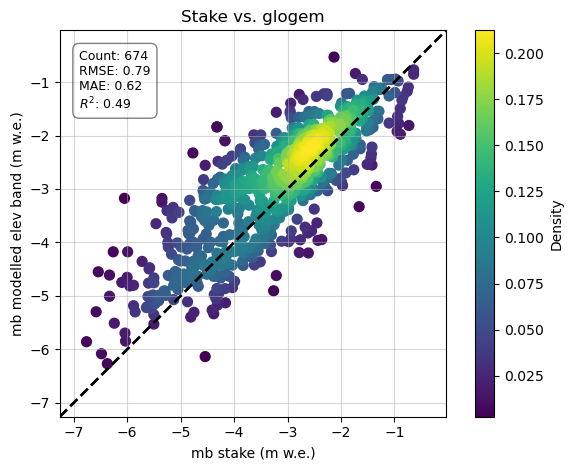

In [27]:
# TEST PLOT
plot_point_modelled(df_test_summer, 'glogem', 1980, 2019)

## Get ML-model predictions

In [28]:
# Model trained on cluster using up to 0.2 for learning rate. 
# Learning rate [0.01, 0.1, 0.2]
# Max depth [2, 4, 6]
# n_estimators [50, 100, 200, 300]
#with open('Training_cluster/2024-07-10_20-37-03/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using extended grid search (after implementing custom loss funciton performance improvement)
# param_ranges = {'max_depth': [4, 5, 6, 7, 8], # Depth of tree
#                'n_estimators': [200, 300, 400, 500, 600, 700], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15, 0.2, 0.25], #[0,1]
#with open('Training_cluster/2024-08-06_12-07-32/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ALL ANNUAL, SUMMER, WINTER DATA
with open('Training_cluster/2024-10-24_10-30-28/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ALL ANNUAL AND WINTER DATA
#with open('Training_cluster/2024-10-25_09-45-30/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)


best_model = clf_loaded.best_estimator_
#best_model = CustomXGBRegressor(max_depth=5, learning_rate=0.05, n_estimators=200, gamma=0, random_state=23, min_child_weight=0)
#best_model.fit(X_train, y_train)

In [29]:
best_model

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.05,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=5, max_leaves=None,
                   min_child_weight=0, missing=nan, monotone_constraints=None,
                   multi_strategy=None, n_estimators=300, n_jobs=None,
                   num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000001F0E9183520>, ...)

C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


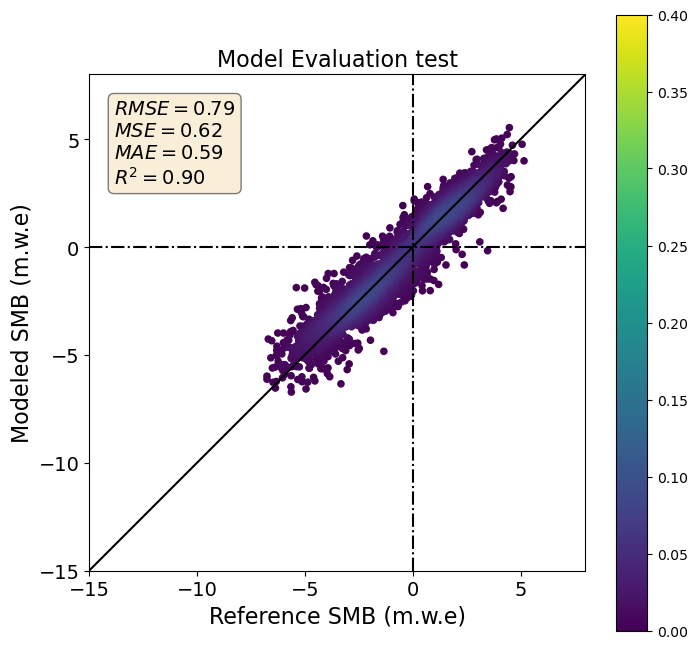

In [30]:
test_pred = best_model.predict(X_test)

# Get test true values and predictions
y_test_mean, y_test_pred_agg = get_ytrue_y_pred_agg(y_test,test_pred,X_test)

# Plot predictions vs true values for test
plot_prediction(y_test_mean, y_test_pred_agg, data_type='test')

In [31]:
y_test_winter, y_pred_winter = get_prediction_per_season_test(X_test, y_test, best_model, months=7)
winter_indices = X_test[:, -2] == 7
X_test_winter = X_test[winter_indices]
y_test_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_test_winter, y_pred_winter, X_test_winter, months=7)

df_test_winter['mb_ML'] = y_pred_winter_agg

In [32]:
df_test_winter

BREID  altitude  altitude_climate  year  altitude_diff  balance  \
0      54.0     471.0        341.227919  2013    -129.772081     1.32   
1      54.0     439.0        341.227919  2014     -97.772081     1.68   
2      54.0     444.0        341.227919  2015    -102.772081     0.76   
3      54.0     444.0        341.227919  2016    -102.772081     0.78   
4      54.0     468.0        341.227919  2017    -126.772081     1.59   
..      ...       ...               ...   ...            ...      ...   
994  3141.0    1078.0        917.419759  2012    -160.580241     1.50   
995  3141.0    1078.0        917.419759  2013    -160.580241     1.14   
996  3141.0    1079.0        917.419759  2015    -161.580241     1.19   
997  3141.0    1078.0        917.419759  2016    -160.580241     1.72   
998  3141.0    1078.0        917.419759  2017    -160.580241     1.15   

       aspect     slope  skyview_factor  n_months  ...           slhf  \
0    0.629597  0.278773        0.778997       7.0  ...   62438.500000   
1    0.585924  0.296590        0.798494       7.0  ...   65465.714286   
2    0.663261  0.302508        0.803510       7.0  ...   21334.214286   
3    0.663261  0.302508        0.803510       7.0  ...  102229.642857   
4    0.836757  0.309196        0.817480       7.0  ...   64772.571429   
..        ...       ...             ...       ...  ...            ...   
994  2.906044  0.131717        0.932281       7.0  ... -171713.642857   
995  2.906044  0.131717        0.932281       7.0  ... -123023.142857   
996  2.906044  0.131717        0.932281       7.0  ... -271647.642857   
997  2.906044  0.131717        0.932281       7.0  ... -251040.928571   
998  2.906044  0.131717        0.932281       7.0  ... -255928.142857   

             ssrd       fal           str        tp    ID  mb_glogem  \
0    3.477078e+06  0.749392 -2.148801e+06  0.003397  1258      1.226   
1    3.052352e+06  0.758143 -2.145037e+06  0.003847  1258        NaN   
2    3.186665e+06  0.750785 -2.258321e+06  0.002979  1258      1.055   
3    3.540237e+06  0.771447 -2.084224e+06  0.003243  1258      0.773   
4    3.494867e+06  0.679859 -2.391737e+06  0.003806  1258      1.073   
..            ...       ...           ...       ...   ...        ...   
994  4.804682e+06  0.683440 -1.769234e+06  0.010046  2969      1.795   
995  5.492646e+06  0.711911 -2.165743e+06  0.006262  2969      1.639   
996  4.664342e+06  0.653273 -1.837262e+06  0.011195  2969      1.681   
997  5.058185e+06  0.655849 -1.987646e+06  0.009280  2969      2.123   
998  4.882558e+06  0.674844 -1.963044e+06  0.008427  2969      1.972   

      mb_oggm  mb_pygem     mb_ML  
0    1.777994  1.783696  1.444547  
1    1.695268       NaN  1.899905  
2    1.344041       NaN  1.364813  
3    1.674745       NaN  1.783165  
4    1.803798       NaN  1.843004  
..        ...       ...       ...  
994  2.973974       NaN  2.120444  
995  2.020106       NaN  1.299575  
996  2.814881       NaN  2.329732  
997  2.788278       NaN  1.805306  
998  2.333989       NaN  1.541409  

[999 rows x 22 columns]

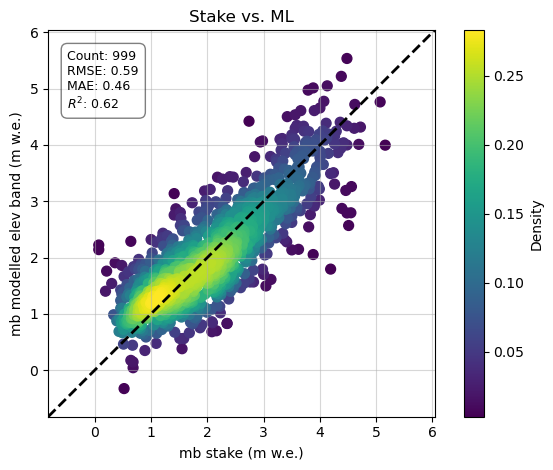

In [33]:
plot_point_modelled(df_test_winter, 'ML', 1959, 2022)

In [34]:
df_test_summer

BREID  altitude  altitude_climate  year  altitude_diff  balance  \
0       54.0     471.0        341.227919  2013    -129.772081    -6.24   
1       54.0     439.0        341.227919  2014     -97.772081    -4.35   
2       54.0     444.0        341.227919  2015    -102.772081    -4.17   
3       54.0     444.0        341.227919  2016    -102.772081    -4.37   
4       54.0     468.0        341.227919  2017    -126.772081    -4.05   
...      ...       ...               ...   ...            ...      ...   
1023  3141.0    1078.0        917.419759  2012    -160.580241    -3.57   
1024  3141.0    1078.0        917.419759  2013    -160.580241    -4.29   
1025  3141.0    1079.0        917.419759  2015    -161.580241    -3.80   
1026  3141.0    1078.0        917.419759  2016    -160.580241    -4.38   
1027  3141.0    1078.0        917.419759  2017    -160.580241    -4.44   

        aspect     slope  skyview_factor  n_months  ...          sshf  \
0     0.629597  0.278773        0.778997       5.0  ... -1.144397e+06   
1     0.585924  0.296590        0.798494       5.0  ... -8.530628e+05   
2     0.663261  0.302508        0.803510       5.0  ... -1.004910e+06   
3     0.663261  0.302508        0.803510       5.0  ... -1.251008e+06   
4     0.836757  0.309196        0.817480       5.0  ... -5.285949e+05   
...        ...       ...             ...       ...  ...           ...   
1023  2.906044  0.131717        0.932281       5.0  ... -8.508311e+05   
1024  2.906044  0.131717        0.932281       5.0  ... -1.181479e+06   
1025  2.906044  0.131717        0.932281       5.0  ... -3.370901e+05   
1026  2.906044  0.131717        0.932281       5.0  ... -9.977858e+05   
1027  2.906044  0.131717        0.932281       5.0  ... -1.012121e+06   

            slhf        ssrd       fal         str        tp    ID mb_glogem  \
0    -2949888.30  14333271.4  0.234405 -4096567.90  0.002866  1258    -5.511   
1    -2240188.45  14340004.3  0.343329 -3613599.05  0.002707  1258       NaN   
2    -2382853.60  13163506.1  0.284936 -3492518.15  0.003367  1258    -4.864   
3    -2698309.70  12194028.9  0.217927 -3390287.60  0.002925  1258    -4.975   
4    -1884445.15  13869421.1  0.341601 -3293730.55  0.003186  1258    -3.282   
...          ...         ...       ...         ...       ...   ...       ...   
1023 -1724419.25  14346574.6  0.356145 -2481046.90  0.006822  2969    -3.397   
1024 -2503409.00  14099480.7  0.302352 -2946410.05  0.006346  2969    -4.962   
1025 -1079567.30  14448706.6  0.430668 -1973078.45  0.006524  2969    -2.404   
1026 -2213228.25  13748145.0  0.285253 -2613071.80  0.007863  2969    -4.635   
1027 -2222112.90  13117023.7  0.292764 -2453521.90  0.006619  2969    -3.994   

       mb_oggm  mb_pygem  
0    -5.881738 -6.302854  
1    -4.654542       NaN  
2    -4.283437       NaN  
3    -5.313028       NaN  
4    -4.154375       NaN  
...        ...       ...  
1023 -4.830727       NaN  
1024 -5.690383       NaN  
1025 -4.520886       NaN  
1026 -5.891730       NaN  
1027 -5.305985       NaN  

[1028 rows x 21 columns]

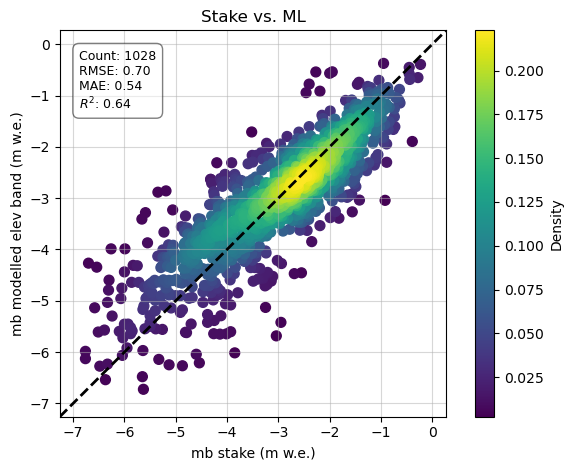

In [35]:
y_test_summer, y_pred_summer = get_prediction_per_season_test(X_test, y_test, best_model, months=5)
summer_indices = X_test[:, -2] == 5
X_test_summer = X_test[summer_indices]
y_test_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_test_summer, y_pred_summer, X_test_summer, months=5)

df_test_summer['mb_ML'] = y_pred_summer_agg
plot_point_modelled(df_test_summer, 'ML', 1959, 2022)

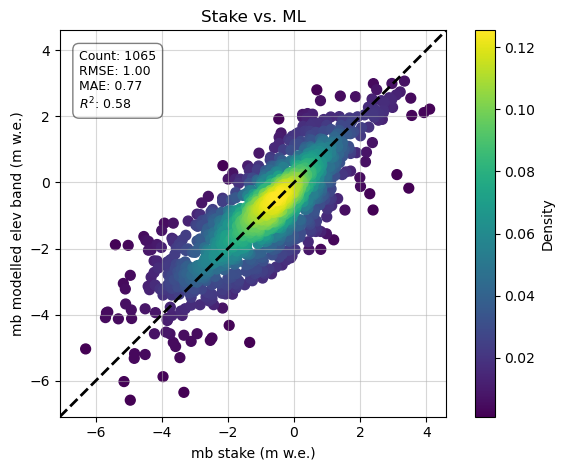

In [36]:
y_test_annual, y_pred_annual = get_prediction_per_season_test(X_test, y_test, best_model, months=12)
annual_indices = X_test[:, -2] == 12
X_test_annual = X_test[annual_indices]
y_test_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_test_annual, y_pred_annual, X_test_annual, months=12)

df_test_annual['mb_ML'] = y_pred_annual_agg
plot_point_modelled(df_test_annual, 'ML', 1959, 2022)

## Predict annual mass balance from seasonal mass balance, gives same results

In [37]:
# Predict annual mass balance from sum of seasonal mass balance

# Define the months for each group
winter_months = {'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr'}
summer_months = {'may', 'jun', 'jul', 'aug', 'sep'}

# Create a boolean mask for each group
winter_mask = np.isin(X_test_annual[:, -1], list(winter_months))
summer_mask = np.isin(X_test_annual[:, -1], list(summer_months))

# Create subsets using the masks
X_test_winter_sum = X_test_annual[winter_mask]
X_test_summer_sum = X_test_annual[summer_mask]

# Modify the second to last column for each subset
X_test_winter_sum[:, -2] = 7
X_test_summer_sum[:, -2] = 5

# Dummies
y_test_winter_sum = y_test_annual[winter_mask]
y_test_summer_sum = y_test_annual[summer_mask]
#y_test_winter_sum[:, -2] = 7
#y_test_summer_sum[:, -2] = 5

In [38]:
test_winter_sum_pred = best_model.predict(X_test_winter_sum)
test_summer_sum_pred = best_model.predict(X_test_summer_sum)

In [39]:
# Get test true values and predictions
y_test_winter_sum_mean, y_pred_winter_sum_agg = get_ytrue_y_pred_agg(y_test_winter_sum,test_winter_sum_pred,X_test_winter_sum)
y_test_summer_sum_mean, y_pred_summer_sum_agg = get_ytrue_y_pred_agg(y_test_summer_sum,test_summer_sum_pred,X_test_summer_sum)


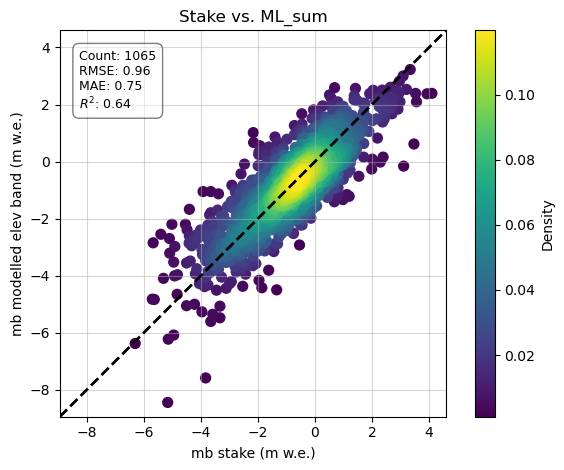

In [218]:
df_test_annual['mb_ML_sum'] = y_pred_winter_sum_agg + y_pred_summer_sum_agg
plot_point_modelled(df_test_annual, 'ML_sum', 1959, 2022)

In [219]:
df_test_annual[['mb_ML','mb_ML_sum']]

mb_ML  mb_ML_sum
0    -4.006602  -4.006602
1    -3.290628  -3.290628
2    -3.268812  -3.268812
3    -3.447045  -3.447045
4    -3.026467  -3.026467
...        ...        ...
1060 -1.390846  -1.390846
1061 -3.161398  -3.161398
1062 -1.660244  -1.660244
1063 -3.311808  -3.311808
1064 -2.896966  -2.896966

[1065 rows x 2 columns]

## Plot modelled point mass balance against observed point mass balance for all models

In [37]:
# PLOT POINTS WITH GAUSSIAN KDE (WORKS ONLY FOR COMMON TIME PERIOD DUE TO SORTING)
# Three dataframes that only contain predictions for test glaciers:
# df_test_annual
# df_test_winter
# df_test_summer

# Each df contains the following columns: 
# year, balance, mb_glogem, mb_oggm, mb_pygem, mb_ML

# Set the start and end years for the filter
start_year = 1979
end_year = 2019

gl = 'all'

# Function to filter DataFrame based on year range
def filter_df_by_year(df, start_year, end_year):
    return df[(df['year'] >= start_year) & (df['year'] <= end_year)]

# Filter the DataFrames
#df_obs_nonan = df_obs.dropna(subset=['RGIID'])
if gl == 'test':
    print('test')
    #df_obs_nonan = filter_df_by_rgiid_and_year(df_obs_nonan, test_glaciers, start_year, end_year)
    #df_pred_filtered = filter_df_by_rgiid_and_year(df_pred, test_glaciers, start_year, end_year)
    #df_oggm_filtered = filter_df_by_rgiid_and_year(df_oggm, test_glaciers, start_year, end_year)
    #df_glogem_filtered = filter_df_by_rgiid_and_year(df_glogem, test_glaciers, start_year, end_year)
    #df_pygem_filtered = filter_df_by_rgiid_and_year(df_pygem, test_glaciers, start_year, end_year)
elif gl == 'all':
    df_annual_filtered = filter_df_by_year(df_test_annual, start_year, end_year)
    df_winter_filtered = filter_df_by_year(df_test_winter, start_year, end_year)
    df_summer_filtered = filter_df_by_year(df_test_summer, start_year, end_year)

# List of model columns and corresponding labels#
    #models = [('mb_ML', 'XGBoost')]

models = [('mb_ML', 'Mass Balance Machine'), ('mb_oggm', 'OGGM'), ('mb_glogem', 'GloGEM'), ('mb_pygem', 'PyGEM')]

def remove_nan_rows(df, model_cols):
    """Remove rows with NaNs in the 'balance' column or any of the model columns."""
    columns_to_check = ['balance'] + model_cols
    return df.dropna(subset=columns_to_check)



In [38]:
# List of model columns
#model_cols = ['mb_ML']
model_cols = ['mb_ML', 'mb_oggm', 'mb_glogem', 'mb_pygem']

# Filter DataFrames to remove rows with NaNs in relevant columns
df_annual_filtered = remove_nan_rows(df_annual_filtered, model_cols)
df_winter_filtered = remove_nan_rows(df_winter_filtered, model_cols)
df_summer_filtered = remove_nan_rows(df_summer_filtered, model_cols)


In [39]:
# Step 1: Add a 'Type' Column to Each DataFrame
df_annual_filtered['Type'] = 'Ba'
df_winter_filtered['Type'] = 'Bw'
df_summer_filtered['Type'] = 'Bs'

# Step 2: Concatenate the DataFrames into One
combined_df = pd.concat([df_annual_filtered, df_winter_filtered, df_summer_filtered], ignore_index=True)

# Calculate the point density
def gaussian_kde_plot(x_,y_):
    xy = np.vstack([x_,y_])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x_[idx], y_[idx], z[idx]
    return x, y, z

from matplotlib.colors import ListedColormap
my_cmap_blue = sns.dark_palette('tab:blue', n_colors=8, as_cmap=True, reverse=True)
my_cmap_red = sns.dark_palette('tab:red', n_colors=8, as_cmap=True, reverse=True)
my_cmap_black = sns.dark_palette('grey', n_colors=8, as_cmap=True, reverse=True)
my_alpha = 0.5

cm=1/2.54
fontsize = 8
fontsize_small = 8.0
fontsize_min = 8.0
markersize = 20
subplot_labels = ['(a)', '(b)', '(c)', '(d)']

In [40]:
combined_df

BREID  altitude  altitude_climate  year  altitude_diff  balance  \
0       54.0     471.0        341.227919  2013    -129.772081    -4.92   
1       54.0     475.0        341.227919  2018    -133.772081    -4.37   
2       54.0     480.0        341.227919  1997    -138.772081    -2.85   
3       54.0     479.0        341.227919  2001    -137.772081    -3.69   
4       54.0     457.0        341.227919  2003    -115.772081    -2.66   
...      ...       ...               ...   ...            ...      ...   
1589  3141.0    1222.0       1046.032689  2013    -175.967311    -3.83   
1590  3141.0    1221.0       1046.032689  2014    -174.967311    -4.75   
1591  3141.0    1221.0       1046.032689  2015    -174.967311    -3.06   
1592  3141.0    1082.0        917.419759  2009    -164.580241    -4.16   
1593  3141.0    1082.0        917.419759  2010    -164.580241    -3.26   

        aspect     slope  skyview_factor  n_months  ...          ssrd  \
0     0.629597  0.278773        0.778997      12.0  ...  8.000492e+06   
1     0.871247  0.293749        0.813543      12.0  ...  7.234270e+06   
2     0.914653  0.137994        0.758399      12.0  ...  8.140122e+06   
3     0.775073  0.212720        0.767931      12.0  ...  7.232175e+06   
4     0.587371  0.223665        0.780498      12.0  ...  8.149146e+06   
...        ...       ...             ...       ...  ...           ...   
1589  3.090626  0.052604        0.976025       5.0  ...  1.409202e+07   
1590  3.032440  0.060314        0.983040       5.0  ...  1.541981e+07   
1591  3.032440  0.060314        0.983040       5.0  ...  1.462441e+07   
1592  2.906044  0.131717        0.932281       5.0  ...  1.434422e+07   
1593  2.906044  0.131717        0.932281       5.0  ...  1.569967e+07   

           fal           str        tp    ID  mb_glogem   mb_oggm  mb_pygem  \
0     0.534814 -2.960371e+06  0.003176  1258     -4.285 -4.103744 -4.519159   
1     0.535598 -2.749480e+06  0.003266  1258     -4.069 -3.813573 -4.330744   
2     0.603610 -2.776794e+06  0.003198  1258     -2.135 -2.400137 -2.262478   
3     0.542054 -2.677465e+06  0.003104  1258     -3.852 -3.059509 -3.804986   
4     0.596653 -2.840452e+06  0.003283  1258     -2.747 -2.444564 -2.739592   
...        ...           ...       ...   ...        ...       ...       ...   
1589  0.759925 -5.134835e+05  0.006548  2969     -4.430 -4.758966 -4.867850   
1590  0.756143 -6.912250e+05  0.005503  2969     -4.347 -5.390486 -5.698831   
1591  0.782933 -6.737656e+05  0.006596  2969     -2.039 -3.601678 -2.821063   
1592  0.299276 -3.105960e+06  0.007986  2969     -5.129 -5.887157 -6.024286   
1593  0.248455 -4.190417e+06  0.005179  2969     -4.904 -5.041129 -5.850425   

         mb_ML  Type  
0    -3.853414    Ba  
1    -3.240968    Ba  
2    -2.495060    Ba  
3    -3.201490    Ba  
4    -2.404587    Ba  
...        ...   ...  
1589 -2.595989    Bs  
1590 -3.697849    Bs  
1591 -2.567286    Bs  
1592 -4.875295    Bs  
1593 -4.710077    Bs  

[1594 rows x 23 columns]

In [41]:
# Calculate RMSE, MSE, and bias

metrics = {}
labels = ['Mass Balance Machine', 'OGGM', 'GloGEM', 'PyGEM']

print('Metrics based on period :')
print(str(start_year))
print(str(end_year))

for idx, model in enumerate(model_cols):
    label = labels[idx]

    metrics[label] = {}

    for metric in ['Ba', 'Bw', 'Bs']:
        modeled = combined_df[combined_df['Type']==metric][model].values
        observed = combined_df[combined_df['Type']==metric]['balance'].values 
        rmse = root_mean_squared_error(observed, modeled)
        mse = mean_squared_error(observed, modeled)
        mae = np.mean(abs(modeled - observed))
        bias = np.mean(modeled - observed)
        r2 = r2_score(observed, modeled) 
        count = len(observed)  # Count valid pairs
        
        metrics[label][metric] = {'rmse': rmse, 'mse': mse, 'mae': mae, 'bias': bias, 'r2':r2, 'count': count}

        print(f'{label} - {metric}: RMSE={rmse:.2f}, MSE={mse:.2f}, MAE={mae:.2f}, Bias={bias:.2f}, R²={r2:.2f}, Count={count}')


Metrics based on period :
1979
2019
Mass Balance Machine - Ba: RMSE=0.97, MSE=0.95, MAE=0.76, Bias=0.01, R²=0.64, Count=561
Mass Balance Machine - Bw: RMSE=0.55, MSE=0.30, MAE=0.43, Bias=-0.05, R²=0.68, Count=517
Mass Balance Machine - Bs: RMSE=0.70, MSE=0.49, MAE=0.56, Bias=0.10, R²=0.68, Count=516
OGGM - Ba: RMSE=0.93, MSE=0.86, MAE=0.73, Bias=0.02, R²=0.68, Count=561
OGGM - Bw: RMSE=0.82, MSE=0.68, MAE=0.63, Bias=0.26, R²=0.26, Count=517
OGGM - Bs: RMSE=0.89, MSE=0.79, MAE=0.72, Bias=-0.27, R²=0.49, Count=516
GloGEM - Ba: RMSE=0.91, MSE=0.83, MAE=0.71, Bias=-0.02, R²=0.69, Count=561
GloGEM - Bw: RMSE=0.65, MSE=0.42, MAE=0.51, Bias=-0.35, R²=0.55, Count=517
GloGEM - Bs: RMSE=0.79, MSE=0.62, MAE=0.61, Bias=0.29, R²=0.60, Count=516
PyGEM - Ba: RMSE=1.05, MSE=1.09, MAE=0.81, Bias=0.36, R²=0.59, Count=561
PyGEM - Bw: RMSE=0.87, MSE=0.76, MAE=0.69, Bias=0.59, R²=0.17, Count=517
PyGEM - Bs: RMSE=0.93, MSE=0.87, MAE=0.75, Bias=-0.27, R²=0.44, Count=516


In [42]:
# Calculate the point density
def gaussian_kde_plot(x_,y_):
    xy = np.vstack([x_,y_])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x_[idx], y_[idx], z[idx]
    return x, y, z

from matplotlib.colors import ListedColormap
my_cmap_blue = sns.dark_palette('tab:blue', n_colors=8, as_cmap=True, reverse=True)
my_cmap_red = sns.dark_palette('tab:red', n_colors=8, as_cmap=True, reverse=True)
my_cmap_black = sns.dark_palette('grey', n_colors=8, as_cmap=True, reverse=True)
my_alpha = 0.5

cm=1/2.54
fontsize = 8
fontsize_small = 8.0
fontsize_min = 8.0
markersize = 20
subplot_labels = ['(a)', '(b)', '(c)', '(d)']
        

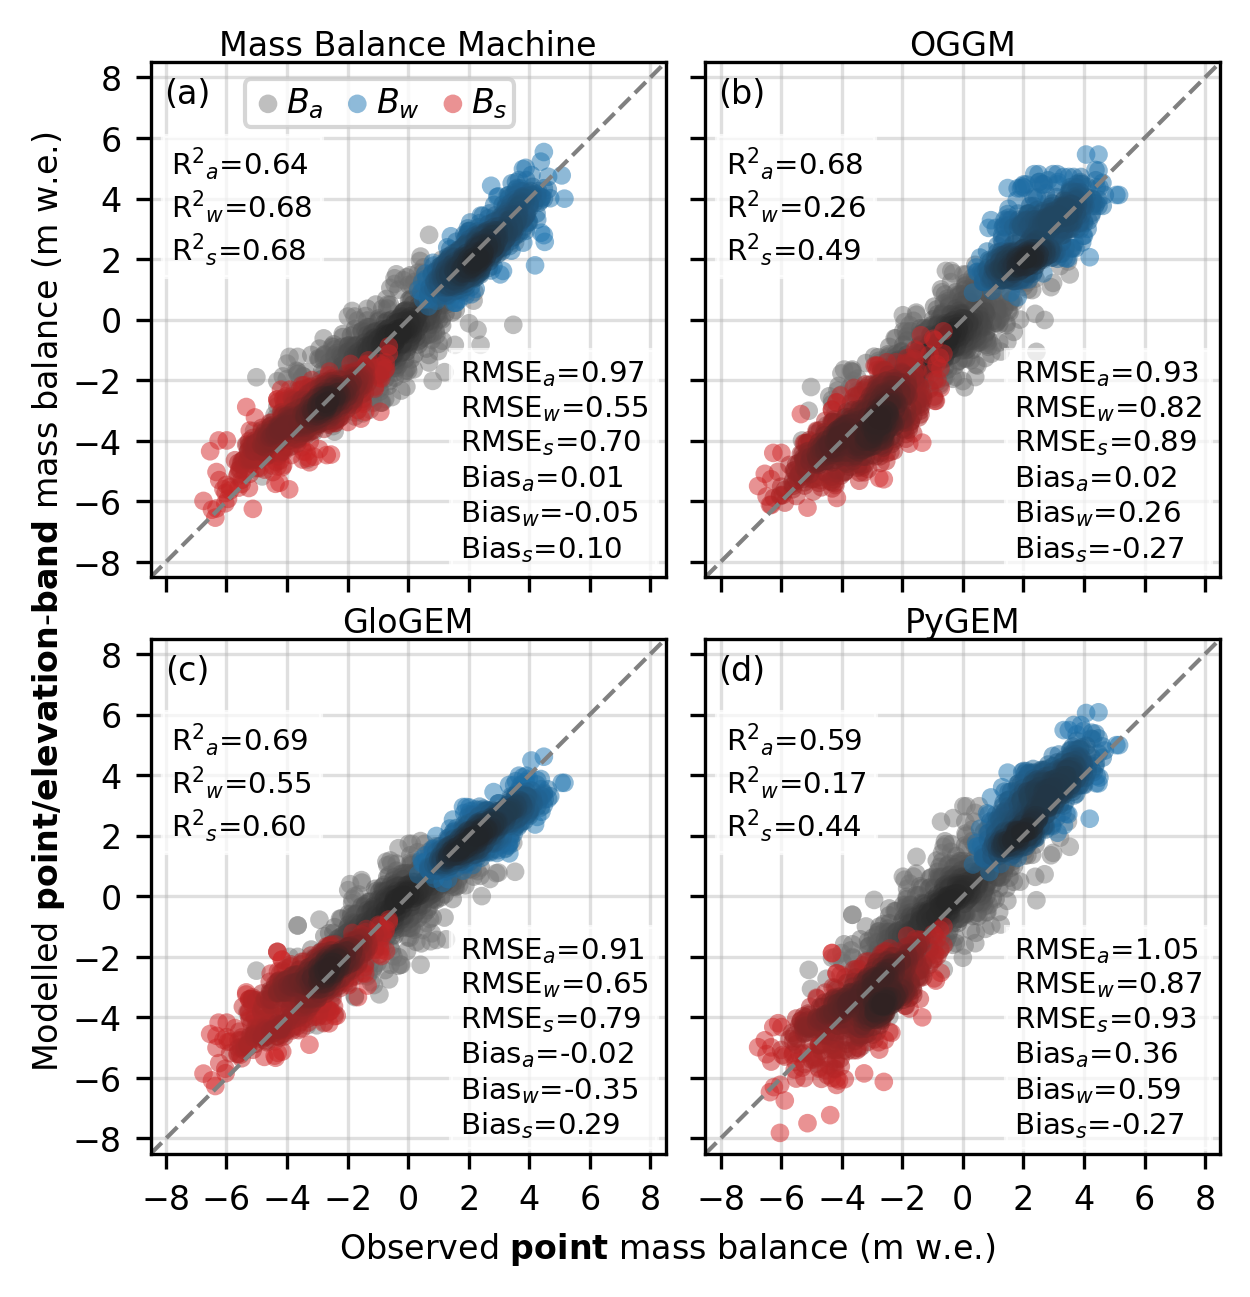

In [43]:
#from matplotlib import rc
#rc('text', usetex=True)

# 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12*cm, 12*cm), sharex=True, sharey=True, dpi=300)
axs = axs.flatten()

tick_min = -8
tick_max = 8
ticks = np.arange(tick_min, tick_max+1, 2)

# model_cols = ['mb_ML', 'mb_oggm', 'mb_glogem', 'mb_pygem']
labels = ['Mass Balance Machine', 'OGGM', 'GloGEM', 'PyGEM']

for idx, model in enumerate(model_cols):
    ax = axs[idx]
    label = labels[idx]
    
    for metric in ['Ba', 'Bw', 'Bs']:
        
        y_ = combined_df[combined_df['Type']==metric][model].values
        x_ = combined_df[combined_df['Type']==metric]['balance'].values     
        x, y, z = gaussian_kde_plot(x_, y_)
        
        if metric == 'Ba':
            ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_black, alpha=my_alpha, label=metric)
        elif metric == 'Bw':
            ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_blue, alpha=my_alpha, label=metric)
        elif metric == 'Bs':
            ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_red, alpha=my_alpha, label=metric)

    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color='gray', linewidth=1)
    ax.set_title(f'{label}', fontsize=fontsize, pad=0.1)
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-8.5, 8.5)
    ax.set_ylim(-8.5, 8.5)
    ax.legend(loc = 'lower right', fontsize=fontsize)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_axisbelow(True)
    ax.grid(alpha=0.4)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_small)
    
    rmse_list = [f"RMSE$_{{{metric[-1]}}}$={metrics[label][metric]['rmse']:.2f}" for metric in ['Ba', 'Bw', 'Bs']]
    mbe_list = [f"Bias$_{{{metric[-1]}}}$={metrics[label][metric]['bias']:.2f}" for metric in ['Ba', 'Bw', 'Bs']]
    textstr = '\n'.join(rmse_list + mbe_list)

    r2_list = [f"R$^2$$_{{{metric[-1]}}}$={metrics[label][metric]['r2']:.2f}" for metric in ['Ba', 'Bw', 'Bs']]
    textstr2 = '\n'.join(r2_list)

    ax.text(0.6, 0.025, textstr, transform=ax.transAxes, fontsize=7, #wrap=True,
            verticalalignment='bottom', bbox=dict(boxstyle='square', color='white', alpha=0.7))
    
    ax.text(0.04, 0.6, textstr2, transform=ax.transAxes, fontsize=7, #wrap=True,
            verticalalignment='bottom', bbox=dict(boxstyle='square', color='white', alpha=0.7))
    
    ax.annotate(subplot_labels[idx], xy=(0.07, 0.97), xycoords='axes fraction', fontsize=fontsize_small,# fontweight='bold',
                ha='center', va='top')
    
    ax.legend().remove()

for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('')

axs[0].legend(['$B_{a}$','$B_{w}$','$B_{s}$'],loc = 'upper left', fontsize=fontsize_small, 
              handlelength= 1, handletextpad=0.05,borderpad=0.2,labelspacing=0.2, ncols=3, columnspacing=0.5, bbox_to_anchor=(0.15,1.0))

fig.supxlabel('Observed $\mathbf{point}$ mass balance (m w.e.)', fontsize=fontsize, y=0.03)#, labelpad = 16)
fig.supylabel('Modelled $\mathbf{point/elevation}$-$\mathbf{band}$ mass balance (m w.e.)', fontsize=fontsize, x=0.05)#, labelpad = 16)

plt.subplots_adjust(wspace=0.02, hspace=0.12)

#pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
#plt.savefig(pdf_path+'comparison_point_test_common_obs_kde.pdf', format='pdf', bbox_inches='tight')

plt.show()

## Elevation-band performance of XGBoost

In [44]:
combined_df

BREID  altitude  altitude_climate  year  altitude_diff  balance  \
0       54.0     471.0        341.227919  2013    -129.772081    -4.92   
1       54.0     475.0        341.227919  2018    -133.772081    -4.37   
2       54.0     480.0        341.227919  1997    -138.772081    -2.85   
3       54.0     479.0        341.227919  2001    -137.772081    -3.69   
4       54.0     457.0        341.227919  2003    -115.772081    -2.66   
...      ...       ...               ...   ...            ...      ...   
1589  3141.0    1222.0       1046.032689  2013    -175.967311    -3.83   
1590  3141.0    1221.0       1046.032689  2014    -174.967311    -4.75   
1591  3141.0    1221.0       1046.032689  2015    -174.967311    -3.06   
1592  3141.0    1082.0        917.419759  2009    -164.580241    -4.16   
1593  3141.0    1082.0        917.419759  2010    -164.580241    -3.26   

        aspect     slope  skyview_factor  n_months  ...          ssrd  \
0     0.629597  0.278773        0.778997      12.0  ...  8.000492e+06   
1     0.871247  0.293749        0.813543      12.0  ...  7.234270e+06   
2     0.914653  0.137994        0.758399      12.0  ...  8.140122e+06   
3     0.775073  0.212720        0.767931      12.0  ...  7.232175e+06   
4     0.587371  0.223665        0.780498      12.0  ...  8.149146e+06   
...        ...       ...             ...       ...  ...           ...   
1589  3.090626  0.052604        0.976025       5.0  ...  1.409202e+07   
1590  3.032440  0.060314        0.983040       5.0  ...  1.541981e+07   
1591  3.032440  0.060314        0.983040       5.0  ...  1.462441e+07   
1592  2.906044  0.131717        0.932281       5.0  ...  1.434422e+07   
1593  2.906044  0.131717        0.932281       5.0  ...  1.569967e+07   

           fal           str        tp    ID  mb_glogem   mb_oggm  mb_pygem  \
0     0.534814 -2.960371e+06  0.003176  1258     -4.285 -4.103744 -4.519159   
1     0.535598 -2.749480e+06  0.003266  1258     -4.069 -3.813573 -4.330744   
2     0.603610 -2.776794e+06  0.003198  1258     -2.135 -2.400137 -2.262478   
3     0.542054 -2.677465e+06  0.003104  1258     -3.852 -3.059509 -3.804986   
4     0.596653 -2.840452e+06  0.003283  1258     -2.747 -2.444564 -2.739592   
...        ...           ...       ...   ...        ...       ...       ...   
1589  0.759925 -5.134835e+05  0.006548  2969     -4.430 -4.758966 -4.867850   
1590  0.756143 -6.912250e+05  0.005503  2969     -4.347 -5.390486 -5.698831   
1591  0.782933 -6.737656e+05  0.006596  2969     -2.039 -3.601678 -2.821063   
1592  0.299276 -3.105960e+06  0.007986  2969     -5.129 -5.887157 -6.024286   
1593  0.248455 -4.190417e+06  0.005179  2969     -4.904 -5.041129 -5.850425   

         mb_ML  Type  
0    -3.853414    Ba  
1    -3.240968    Ba  
2    -2.495060    Ba  
3    -3.201490    Ba  
4    -2.404587    Ba  
...        ...   ...  
1589 -2.595989    Bs  
1590 -3.697849    Bs  
1591 -2.567286    Bs  
1592 -4.875295    Bs  
1593 -4.710077    Bs  

[1594 rows x 23 columns]

In [47]:
# Ensure seaborn defaults are used for plots
#sns.set()
import glob
import os

start_year = 1979
end_year = 2019

# Path to the folder containing the CSV files
folder_path = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_2024-10-24_10-30-28/'

# List of test glaciers to include
test_glaciers = ['00434', '00449', '01013', '01026', '01258', '01286', '01484', '01598', '02384', '02650', '02916', '02918', '02920', '02969']

# Get a list of all CSV files in the folder
file_list = glob.glob(os.path.join(folder_path, '*.csv'))

# Filter the file_list to include only the files with the IDs in test_glaciers
filtered_file_list = [filename for filename in file_list if any(glacier_id in filename for glacier_id in test_glaciers)]

# DataFrame to store results
columns = ['ID', 'year', 'elevation_bins', 'mb_annual_ml', 'mb_summer_ml', 'mb_winter_ml']
results_df = pd.DataFrame(columns=columns)

# Number of rows and columns for the subplots
nrows = 7
ncols = 2

cm=1/2.54
fontsize=7

# Create a figure with the specified number of subplots
#fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 30))
#axes = axes.flatten()

for idx, filename in enumerate(filtered_file_list):
    if idx >= nrows * ncols:
        break  # Stop if we have more files than subplots

    # Read each CSV file into a DataFrame
    df_pred = pd.read_csv(filename)
    df_pred = df_pred[(df_pred['year']>=start_year) & (df_pred['year']<=end_year)]
    
    # Ensure the DataFrame contains the necessary columns
    required_columns = ['altitude', 'Ba_pred', 'Bs_pred', 'Bw_pred', 'year']
    if not all(column in df_pred.columns for column in required_columns):
        print(f"Skipping {filename} as it does not contain the required columns.")
        continue

    # Step 1: Round the minimum and maximum altitude values to the nearest 100 meters
    min_altitude_rounded = np.floor(df_pred['altitude'].min() / 100) * 100
    max_altitude_rounded = np.ceil(df_pred['altitude'].max() / 100) * 100

    # Step 2: Create bins with 100-meter intervals
    bins = np.arange(min_altitude_rounded, max_altitude_rounded + 100, 100)

    # Step 3: Assign altitude intervals to the bins
    df_pred['elevation_bins'] = pd.cut(df_pred['altitude'], bins=bins, right=False)


    # Step 4: Name each interval by the mean (i.e., every whole 50 meters)
    bin_centers = {interval: round((interval.left + interval.right) / 2) for interval in df_pred['elevation_bins'].cat.categories}
    df_pred['elevation_bins'] = df_pred['elevation_bins'].apply(lambda x: bin_centers[x])

    # Step 5: Group by 'altitude_interval' and 'year' to calculate the mean values per year
    yearly_Ba_by_elevation = df_pred.groupby(['elevation_bins']).Ba_pred.mean().reset_index()
    yearly_Bs_by_elevation = df_pred.groupby(['elevation_bins']).Bs_pred.mean().reset_index()
    yearly_Bw_by_elevation = df_pred.groupby(['elevation_bins']).Bw_pred.mean().reset_index()

    # Step 6: Now calculate the mean, min, and max of these yearly means for each altitude interval
    agg_Ba_by_elevation = yearly_Ba_by_elevation.groupby('elevation_bins').agg(
        mean_Ba=('Ba_pred', 'mean'),
        #mean_Ba=('Ba_pred', 'median'),
        min_Ba=('Ba_pred', 'min'),
        max_Ba=('Ba_pred', 'max')
    ).reset_index()

    agg_Bs_by_elevation = yearly_Bs_by_elevation.groupby('elevation_bins').agg(
        mean_Bs=('Bs_pred', 'mean'),
        #mean_Bs=('Bs_pred', 'median'),
        min_Bs=('Bs_pred', 'min'),
        max_Bs=('Bs_pred', 'max')
    ).reset_index()

    agg_Bw_by_elevation = yearly_Bw_by_elevation.groupby('elevation_bins').agg(
        mean_Bw=('Bw_pred', 'mean'),
        #mean_Bw=('Bw_pred', 'median'),
        min_Bw=('Bw_pred', 'min'),
        max_Bw=('Bw_pred', 'max')
    ).reset_index()

    # Get the subplot axis
    #ax = axes[idx]

    # Step 7: Plotting
    # Plot shaded area and mean line for Ba_pred
    #ax.fill_betweenx(agg_Ba_by_elevation['elevation_bins'],
    #                 agg_Ba_by_elevation['min_Ba'], agg_Ba_by_elevation['max_Ba'],
    #                 color='gray', alpha=0.3, label='Ba_pred Min-Max Range' if idx == 0 else "")
    #ax.plot(agg_Ba_by_elevation['mean_Ba'], agg_Ba_by_elevation['elevation_bins'],
    #        label='Ba_pred Mean' if idx == 0 else "", color='k')

    # Plot shaded area and mean line for Bs_pred
    #ax.fill_betweenx(agg_Bs_by_elevation['elevation_bins'],
    #                 agg_Bs_by_elevation['min_Bs'], agg_Bs_by_elevation['max_Bs'],
    #                 color='C3', alpha=0.3, label='Bs_pred Min-Max Range' if idx == 0 else "")
    #ax.plot(agg_Bs_by_elevation['mean_Bs'], agg_Bs_by_elevation['elevation_bins'],
    #        label='Bs_pred Mean' if idx == 0 else "", color='C3')

    # Plot shaded area and mean line for Bw_pred
    #ax.fill_betweenx(agg_Bw_by_elevation['elevation_bins'],
    #                 agg_Bw_by_elevation['min_Bw'], agg_Bw_by_elevation['max_Bw'],
    #                 color='C0', alpha=0.3, label='Bw_pred Min-Max Range' if idx == 0 else "")
    #ax.plot(agg_Bw_by_elevation['mean_Bw'], agg_Bw_by_elevation['elevation_bins'],
    #        label='Bw_pred Mean' if idx == 0 else "", color='C0')

    glacier_id = df_pred['RGIID'].iloc[0][-4:]

    # Add the results to the results_df
    #for index, row in agg_Ba_by_elevation.iterrows():
    #    elevation_bin = row['elevation_bins']
    #    mean_Ba = row['mean_Ba']
    #    mean_Bs = agg_Bs_by_elevation.loc[agg_Bs_by_elevation['elevation_bins'] == elevation_bin, 'mean_Bs'].values[0]
    #    mean_Bw = agg_Bw_by_elevation.loc[agg_Bw_by_elevation['elevation_bins'] == elevation_bin, 'mean_Bw'].values[0]
    #    results_df = results_df.append({'ID': glacier_id, 'elevation_bins': elevation_bin, 
    #                                    'mb_annual_ml': mean_Ba, 'mb_summer_ml': mean_Bs, 
    #                                    'mb_winter_ml': mean_Bw}, ignore_index=True)

    # Add the results to the results_df
    temp_df = pd.DataFrame({
        'ID': [glacier_id] * len(agg_Ba_by_elevation),
        'elevation_bins': agg_Ba_by_elevation['elevation_bins'],
        'mb_annual_ml': agg_Ba_by_elevation['mean_Ba'],
        'mb_summer_ml': agg_Bs_by_elevation['mean_Bs'],
        'mb_winter_ml': agg_Bw_by_elevation['mean_Bw']
    })

    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    

    #glacier_df_glogem = df_glogem_mean[df_glogem_mean['ID'] == glacier_id]
    #glacier_df_oggm = df_oggm_mean[df_oggm_mean['ID'] == glacier_id]
    #glacier_df_pygem = df_pygem_mean[df_pygem_mean['ID'] == glacier_id]

    # Plot the mean mass balance values
    # Diamond/dashdot for GloGEM
    # Square/dashed for OGGM
    # Circle/dotted for PyGEM
    #alpha=0.9
    #ax.plot(glacier_df_glogem['mb_annual'], glacier_df_glogem['elevation_bins'].astype(float), label='Annual Mass Balance', 
    #        linestyle='-.',color='k', alpha=alpha)#marker='D', 
    #ax.plot(glacier_df_glogem['mb_winter'], glacier_df_glogem['elevation_bins'].astype(float), label='Winter Mass Balance', 
    #        linestyle='-.', color='C0',alpha=alpha)
    #ax.plot(glacier_df_glogem['mb_summer'], glacier_df_glogem['elevation_bins'].astype(float), label='Summer Mass Balance', 
    #        linestyle='-.', color='C3',alpha=alpha)
    #ax.plot(glacier_df_oggm['mb_annual'], glacier_df_oggm['elevation_bins'].astype(float), label='Annual Mass Balance', 
    #        linestyle='--', color='k',alpha=alpha)
    #ax.plot(glacier_df_oggm['mb_winter'], glacier_df_oggm['elevation_bins'].astype(float), label='Winter Mass Balance', 
    #        linestyle='--', color='C0',alpha=alpha)
    #ax.plot(glacier_df_oggm['mb_summer'], glacier_df_oggm['elevation_bins'].astype(float), label='Summer Mass Balance', 
    #        linestyle='--', color='C3',alpha=alpha)
    #ax.plot(glacier_df_pygem['mb_annual'], glacier_df_pygem['elevation_bins'].astype(float), label='Annual Mass Balance', 
    #        linestyle=':', color='k',alpha=alpha)
    #ax.plot(glacier_df_pygem['mb_winter'], glacier_df_pygem['elevation_bins'].astype(float), label='Winter Mass Balance', 
    #        linestyle=':', color='C0',alpha=alpha)
    #ax.plot(glacier_df_pygem['mb_summer'], glacier_df_pygem['elevation_bins'].astype(float), label='Summer Mass Balance', 
    #        linestyle=':', color='C3',alpha=alpha)
           
    glacier_name = df_pred['BREID'].iloc[0]

    # Add point mass balance observations
    #glacier_obs = df_obs_mean[df_obs_mean['BREID']==glacier_name]
    #ax.scatter(glacier_obs['balance_netto'], glacier_obs['elevation_bins'], marker='o', color='k')
    #ax.scatter(glacier_obs['balance_winter'], glacier_obs['elevation_bins'], marker='o', color='C0')
    #ax.scatter(glacier_obs['balance_summer'], glacier_obs['elevation_bins'], marker='o', color='C3')

    #ann_err = [glacier_obs['balance_netto'] - glacier_obs['min_annual'], glacier_obs['max_annual'] - glacier_obs['balance_netto']]
    #ax.errorbar(glacier_obs['balance_netto'], glacier_obs['elevation_bins'], xerr=ann_err, fmt='.', lw=2, capsize=3, alpha=0.7, zorder=0)
    
    #ax.axvline(x=0, color='grey', linestyle='--')
    # Labels and title for this subplot
    #ax.set_xlabel('Mass balance (m w.e.)', fontsize=fontsize)
    #ax.set_ylabel('Elevation (m)',fontsize=fontsize)
    
    #ax.set_title(f"RGI60-08.{os.path.basename(filename).split('_')[1].split('.')[0]}")
    #ax.set_title(f"RGI60-08.{os.path.basename(filename).split('_')[1].split('.')[0]} - {glacier_name}")
    #ax.grid(alpha=0.2)
# Ensure legends show up
#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right')

# Adjust the layout
#plt.tight_layout(rect=[0, 0, 0.95, 0.97])
#plt.show()


In [48]:
results_df

ID  elevation_bins  mb_annual_ml  mb_summer_ml  mb_winter_ml
0    0434             550     -9.070364     -8.279558     -0.790806
1    0434             650     -5.696228     -6.362123      0.665895
2    0434             750     -5.192130     -6.117982      0.925852
3    0434             850     -5.627178     -6.041232      0.414054
4    0434             950     -4.690078     -5.429391      0.739313
..    ...             ...           ...           ...           ...
107  2969            1250     -0.559950     -3.026493      2.466543
108  2969            1350      0.133471     -2.814534      2.948004
109  2969            1450      0.559823     -2.513462      3.073284
110  2969            1550      1.062921     -2.202391      3.265311
111  2969            1650      1.647030     -1.842103      3.489133

[112 rows x 5 columns]

In [49]:
112*3

336

## Point performance XGBoost Model per glacier

C:\Users\kasj\AppData\Local\Temp\ipykernel_10576\1593023595.py:101: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().remove(ax)  # Disable shared x-axis
C:\Users\kasj\AppData\Local\Temp\ipykernel_10576\1593023595.py:105: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax, axs[0])  # Re-enable shared x-axis if needed


Plot index 11: Setting xticks and xticklabels.


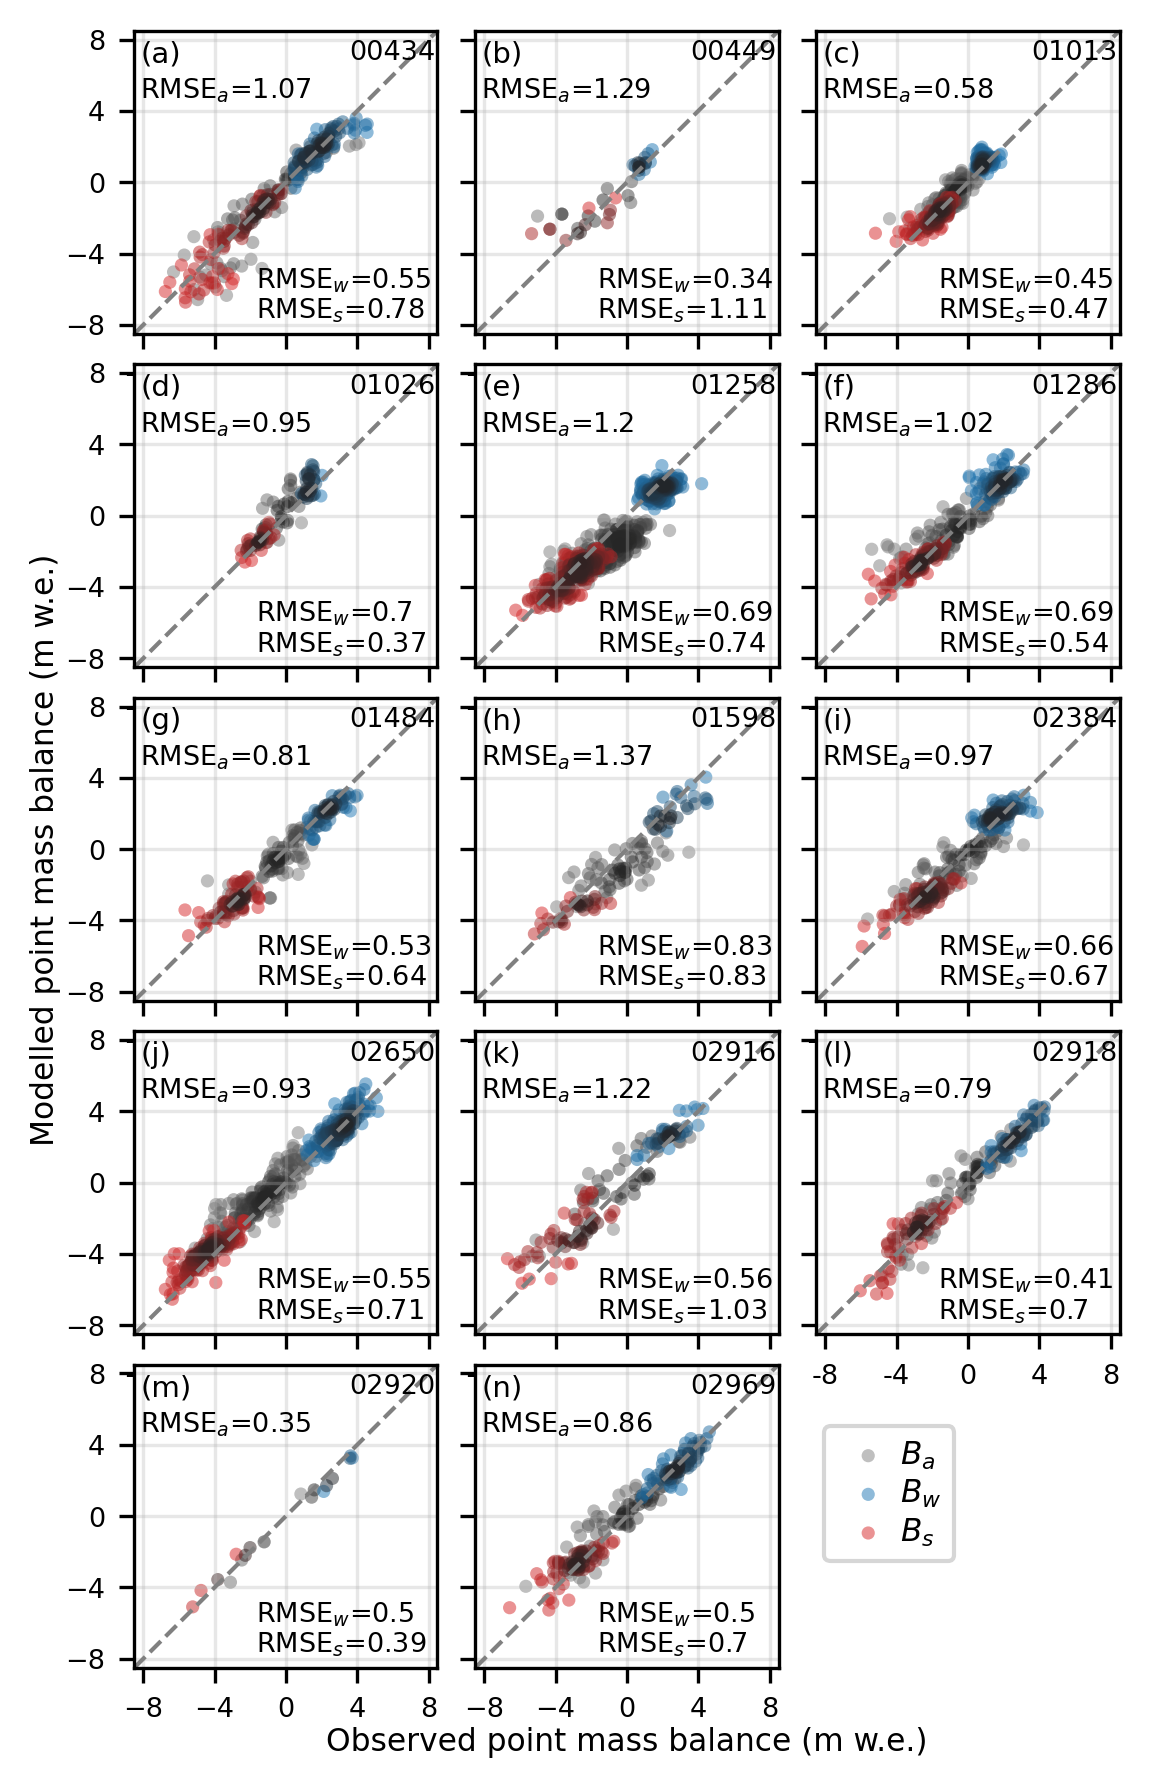

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Function to calculate the point density
def gaussian_kde_plot(x_, y_):
    xy = np.vstack([x_, y_])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    return x_[idx], y_[idx], z[idx]

# Custom colormaps
from matplotlib.colors import ListedColormap
my_cmap_blue = sns.dark_palette('tab:blue', n_colors=8, as_cmap=True, reverse=True)
my_cmap_red = sns.dark_palette('tab:red', n_colors=8, as_cmap=True, reverse=True)
my_cmap_black = sns.dark_palette('grey', n_colors=8, as_cmap=True, reverse=True)
my_alpha = 0.5

# Plot parameters
cm = 1/2.54
fontsize = 7
fontsize_small = 6.5
markersize = 10
subplot_labels = ['(a)', '(b)', '(c)', '(d)']

# Placeholder for the data; you should define combined_df accordingly
# combined_df = ...
# Order test glaciers
test_glaciers = ['0434', '0449', '1013', '1026', '1258', '1286', '1484', '1598', '2384', '2650', '2916', '2918', '2920', '2969']
combined_df_ordered = combined_df[combined_df['ID'].isin(test_glaciers)]
combined_df_ordered['ID'] = pd.Categorical(combined_df_ordered['ID'], categories=test_glaciers, ordered=True)
combined_df_ordered = combined_df_ordered.sort_values('ID')

# Helper Function to Calculate RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Set figure and subplots
fig, axs = plt.subplots(5, 3, figsize=(11 * cm, 18 * cm), sharey=True, dpi=300)
axs = axs.flatten()

# Common properties
tick_min = -8
tick_max = 8
ticks = np.arange(tick_min, tick_max + 1, 4)
model_cols = ['mb_ML']
labels = ['Mass Balance Machine']
glaciers = list(combined_df_ordered.ID.unique())
breid = list(combined_df_ordered.BREID.unique())
n = 14  # Number of glaciers to plot

# Placeholder for metrics; you should define metrics accordingly
# metrics = ...

# Loop through the glaciers
plot_index = 0
for i, glacier in enumerate(glaciers[:n]):
    df_glacier = combined_df_ordered[combined_df_ordered['ID'] == glacier]
    ax = axs[plot_index]

    for idx, model in enumerate(model_cols):
        label = labels[idx]

        for metric in ['Ba', 'Bw', 'Bs']:
            y_ = df_glacier[df_glacier['Type'] == metric][model].values
            x_ = df_glacier[df_glacier['Type'] == metric]['balance'].values
            x, y, z = gaussian_kde_plot(x_, y_)

            if metric == 'Ba':
                ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_black, alpha=my_alpha, label=metric)
                rmse = root_mean_squared_error(x_, y_)
                rmse_txt = "RMSE$_{a}$=" + str(round(rmse, 2))
                ax.annotate(rmse_txt, xy=(0.02, 0.85), xycoords='axes fraction', fontsize=6.5, va='top')
            elif metric == 'Bw':
                ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_blue, alpha=my_alpha, label=metric)
                rmse = root_mean_squared_error(x_, y_)
                rmse_txt = "RMSE$_{w}$=" + str(round(rmse, 2))
                ax.annotate(rmse_txt, xy=(0.4, 0.13), xycoords='axes fraction', fontsize=6.5, va='bottom', ha='left')
            elif metric == 'Bs':
                ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_red, alpha=my_alpha, label=metric)
                rmse = root_mean_squared_error(x_, y_)
                rmse_txt = "RMSE$_{s}$=" + str(round(rmse, 2))
                ax.annotate(rmse_txt, xy=(0.4, 0.03), xycoords='axes fraction', fontsize=6.5, va='bottom', ha='left')

    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color='gray', linewidth=1)
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-8.5, 8.5)
    ax.set_ylim(-8.5, 8.5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_small)
    ax.annotate(f'({chr(97 + plot_index)})', xy=(0.02, 0.97), xycoords='axes fraction', fontsize=7, ha='left', va='top')
    ax.annotate(f'0{glacier}', xy=(0.85, 0.97), xycoords='axes fraction', fontsize=6.5, ha='center', va='top')
    ax.legend().remove()  # Remove individual legends for efficiency

    if plot_index == 11:
        orig_share_x = ax.get_shared_x_axes()
        ax.get_shared_x_axes().remove(ax)  # Disable shared x-axis
        ax.set_xticks(ticks)
        ax.set_xticklabels([-8, -4, 0, 4, 8])
        print(f"Plot index {plot_index}: Setting xticks and xticklabels.")  # Debugging: Verify plot_index 11 is reached
        ax.get_shared_x_axes().join(ax, axs[0])  # Re-enable shared x-axis if needed

    plot_index += 1

# Turn off any extra empty subplots
for ax in axs[plot_index:]:
    ax.axis('off')

# Main legend and labels
axs[plot_index - 1].legend(['$B_{a}$','$B_{w}$','$B_{s}$'], frameon=True, loc='lower left', fontsize=7.5, ncol=1, 
               handlelength=2, handletextpad=0.02, borderaxespad=0.5, borderpad=0.4, labelspacing=0.2, 
               columnspacing=0.8, bbox_to_anchor=(1.1, 0.3))

axs[6].set_ylabel('Modelled point mass balance (m w.e.)', fontsize=7.5, labelpad=1)
axs[13].set_xlabel('Observed point mass balance (m w.e.)', fontsize=7.5, labelpad=1)

plt.subplots_adjust(wspace=0.05, hspace=0.1)

# Uncomment to save the figure
# plt.savefig('path_to_save_plot.pdf', format='pdf', bbox_inches='tight')

plt.show()


## OLD: Plot modelled point mass balance against observed point mass balance for all models

In [47]:
# Plot modelled and observed point mass balances

def plot_point_modelled_subplot(df, model, start_yr, end_yr, ax, min_val=None, max_val=None):
    """
    df : pd.Dataframe of point mb
    type : str, variable in ds; 'netto', 'summer' or 'winter'
    model : str, model name; 'glogem', 'oggm', 'pygem'
    ax: matplotlib Axes object for the subplot
    min_val: float, minimum value for xlim and ylim
    max_val: float, maximum value for xlim and ylim
    """

    df_clean_dropna = df.dropna(subset=['mb_'+model])
    df_clean = df_clean_dropna[(df_clean_dropna['year'] >= start_yr) & (df_clean_dropna['year'] <= end_yr)]

    y_data = df_clean['mb_'+model]
    x_data = df_clean['balance']
    
    xy = np.vstack([x_data, y_data])
    z = gaussian_kde(xy)(xy)

    df_with_density = pd.DataFrame({
        'x': x_data,
        'y': y_data,
        'z': z
    })

    df_with_density.sort_values('z', inplace=True)

    scatter = ax.scatter(df_with_density['x'], df_with_density['y'], c=df_with_density['z'], s=50, cmap='viridis')

    if min_val is None:
        min_val = min(x_data.min(), y_data.min()) - 0.5
    if max_val is None:
        max_val = max(x_data.max(), y_data.max()) + 0.5
    
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='1:1 Line')
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xlabel('mb stake (m w.e.)')
    ax.set_ylabel('mb modelled elev band (m w.e.)')
    ax.set_title('Stake vs. ' + model)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_data, x_data))
    mse = mean_squared_error(y_data, x_data)
    mae = mean_absolute_error(y_data, x_data) 
    r2 = r2_score(y_data, x_data) 
    bias = np.mean(y_data - x_data)
    count = len(x_data)  # Count the number of data points
    
    stats_text = f'Count: {count}\nRMSE: {rmse:.2f}\nMSE: {mse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}\nBias: {bias:.2f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
    
    plt.colorbar(ax.collections[0], ax=ax, label='')
    ax.grid(alpha=0.5)

In [48]:
def plot_all_models(df, models, start_year, end_year, min_val=None, max_val=None):
    """
    df: DataFrame containing the data
    models: List of model names to plot
    start_year: Start year for filtering data
    end_year: End year for filtering data
    min_val: float, override for min value for xlim and ylim
    max_val: float, override for max value for xlim and ylim
    """
    
    # Create a figure with 4 subplots in one row
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), squeeze=False)
    
    for i, model_name in enumerate(models):
        ax = axs[0, i]  # Access each subplot
        plot_point_modelled_subplot(df, model_name, start_year, end_year, ax, min_val=min_val, max_val=max_val)
        
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

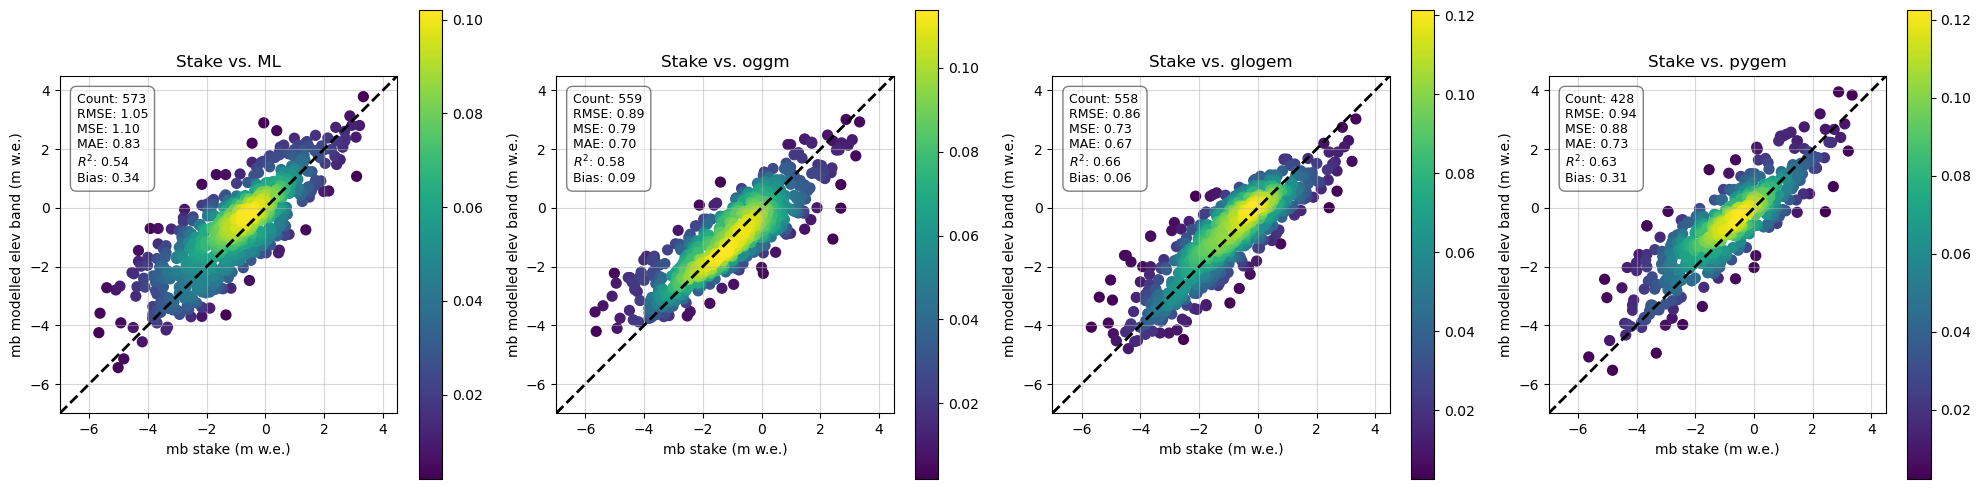

In [49]:
# List of model names
models = ['ML', 'oggm', 'glogem', 'pygem']

plot_all_models(df_test_annual, models, 2000, 2019, min_val=-7, max_val=4.5)

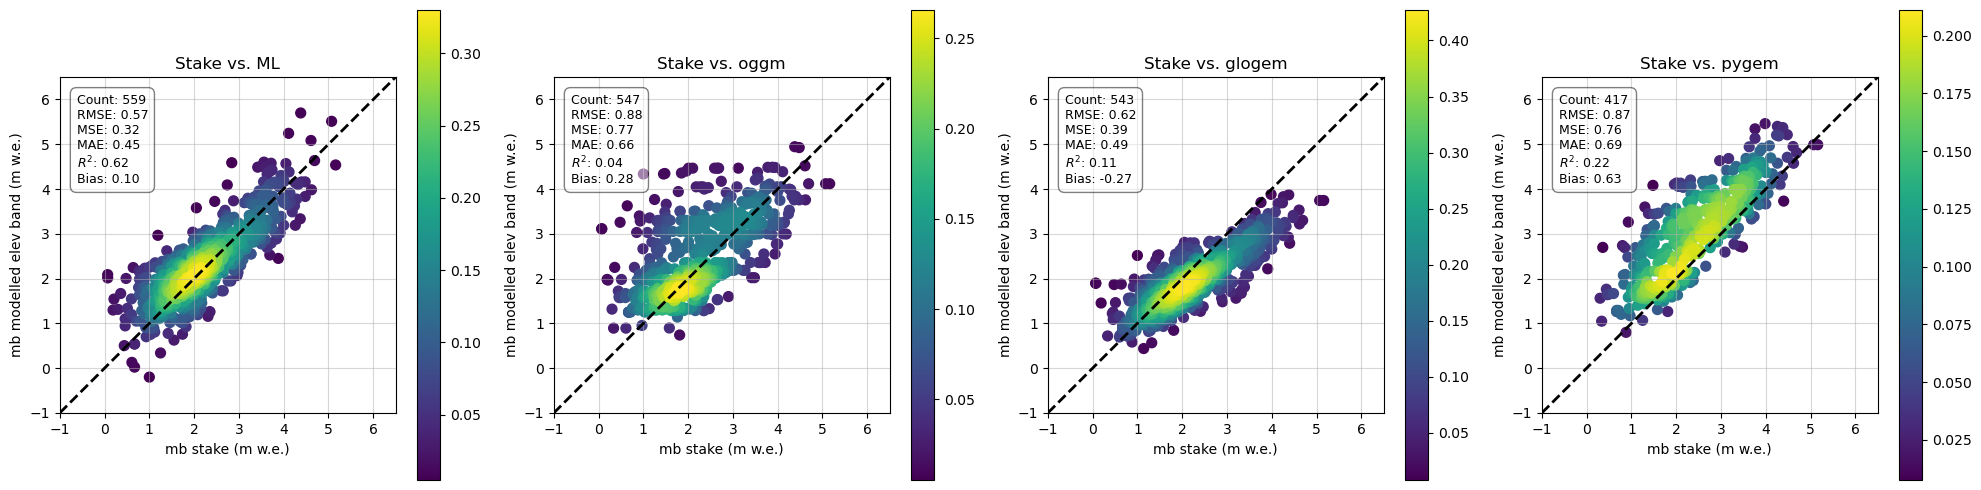

In [50]:
plot_all_models(df_test_winter, models, 2000, 2019, min_val=-1, max_val=6.5)

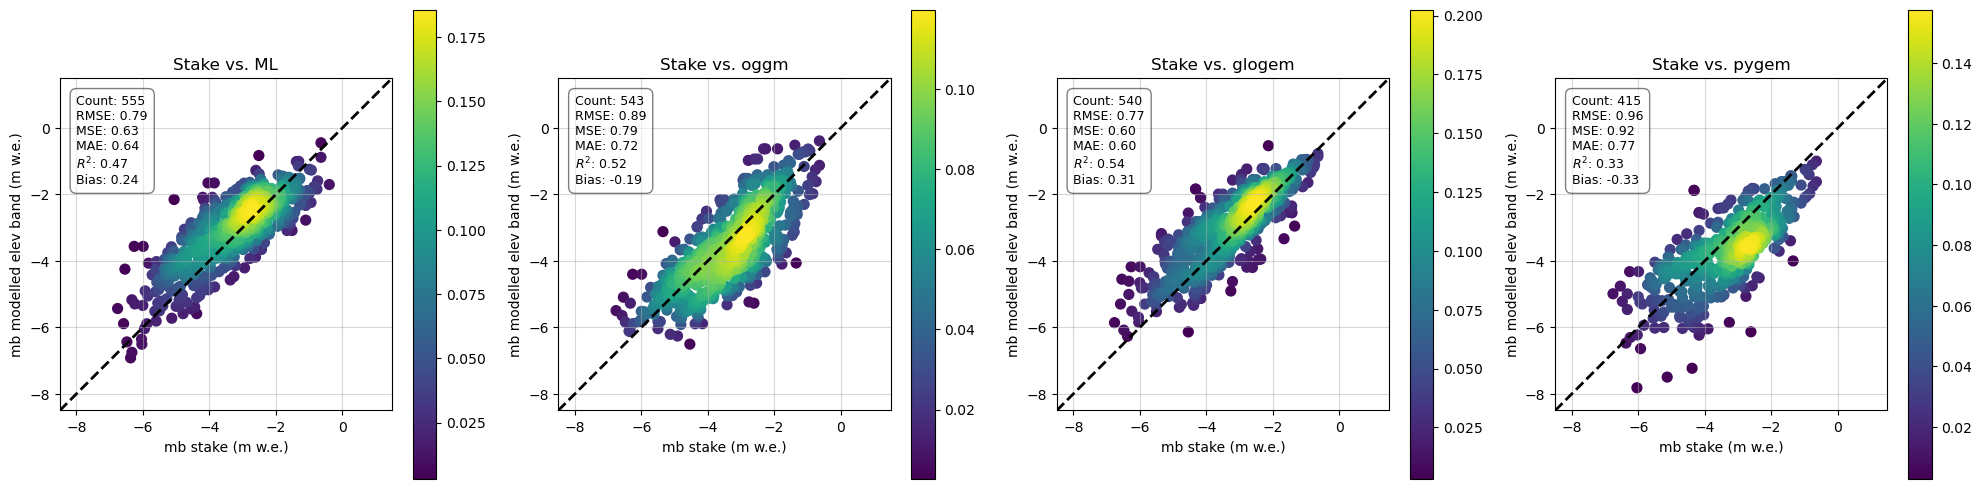

In [51]:
plot_all_models(df_test_summer, models, 2000, 2019, min_val=-8.5, max_val=1.5)

In [52]:
# Filter dataframe with model predictions such that only common values that are not nan are evaluated
# Define the columns to check for NaN values
model_columns = ['mb_ML', 'mb_oggm', 'mb_pygem', 'mb_glogem']

# Filter the DataFrame to select rows where none of the specified columns have NaN values
df_test_annual_nonan = df_test_annual.dropna(subset=model_columns).reset_index(drop=True)
df_test_winter_nonan = df_test_winter.dropna(subset=model_columns).reset_index(drop=True)
df_test_summer_nonan = df_test_summer.dropna(subset=model_columns).reset_index(drop=True)


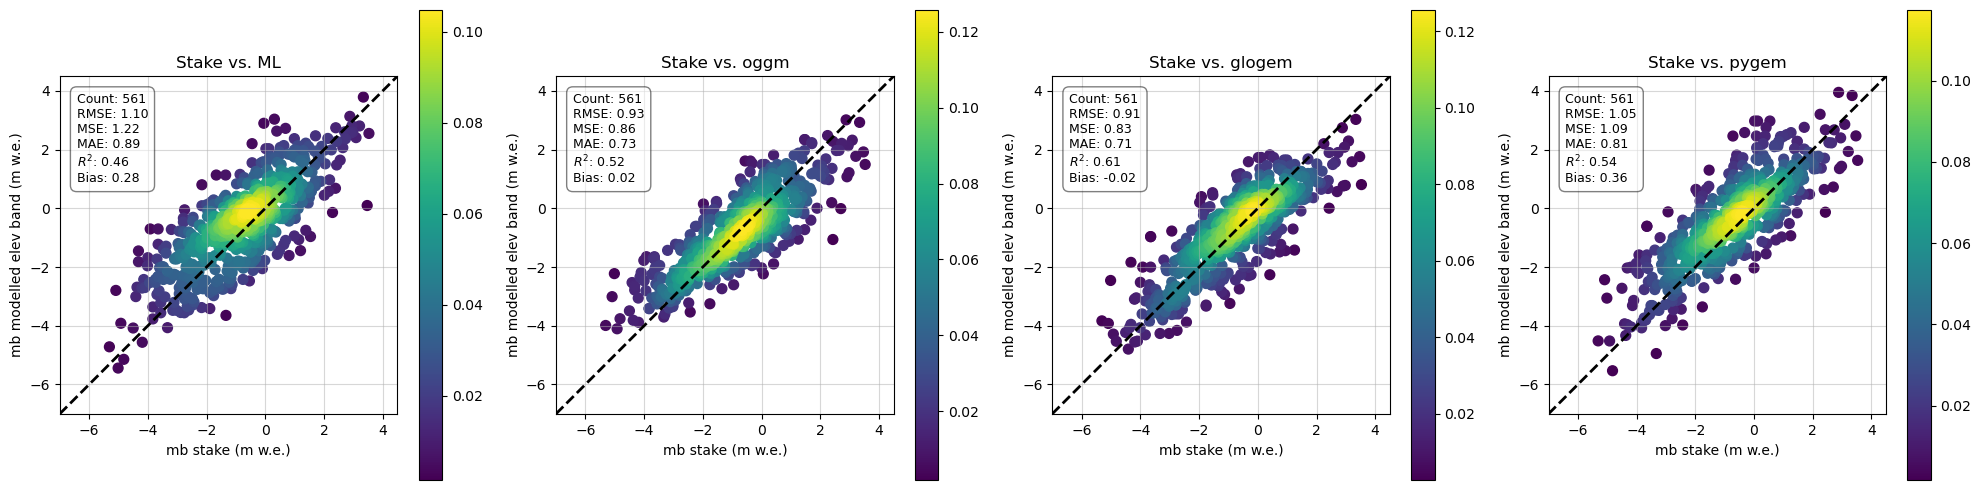

In [53]:
# Annual mb with only common points
plot_all_models(df_test_annual_nonan, models, 1960, 2020, min_val=-7, max_val=4.5)

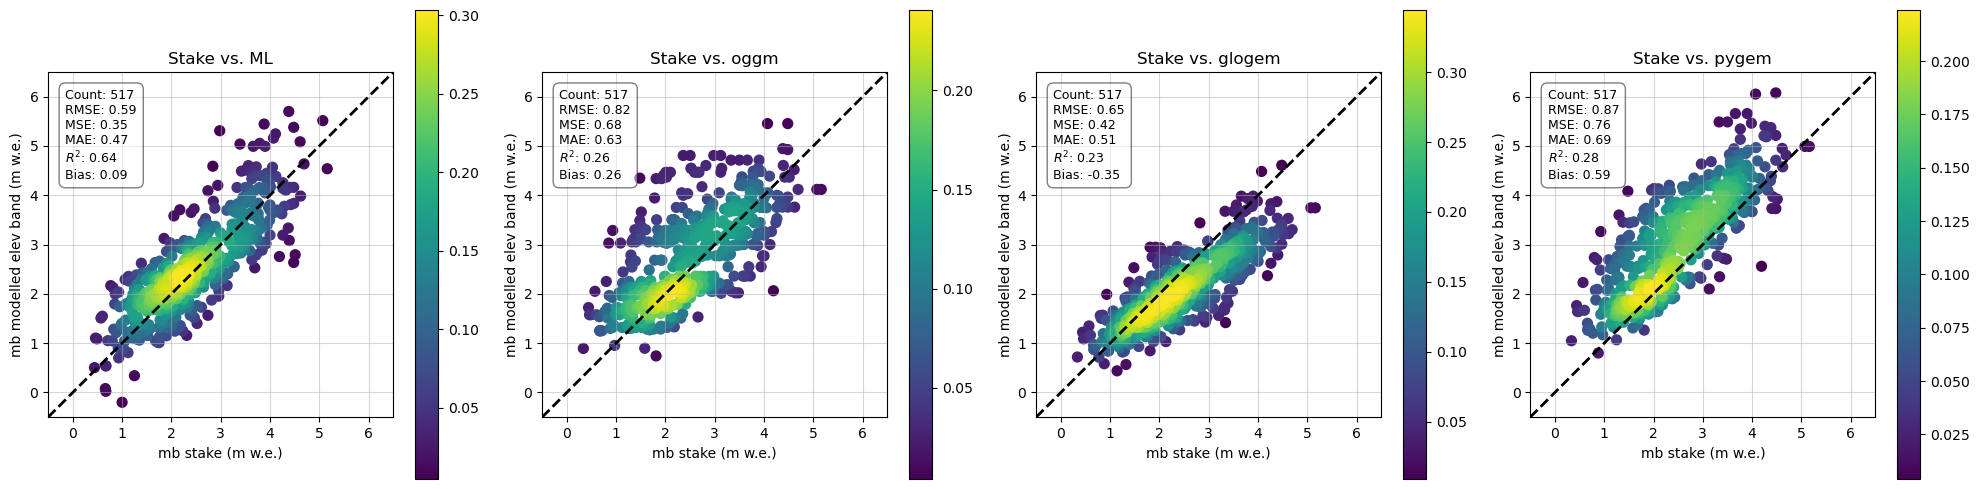

In [54]:
# Winter mb with only common points
plot_all_models(df_test_winter_nonan, models, 1960, 2020, min_val=-0.5, max_val=6.5)

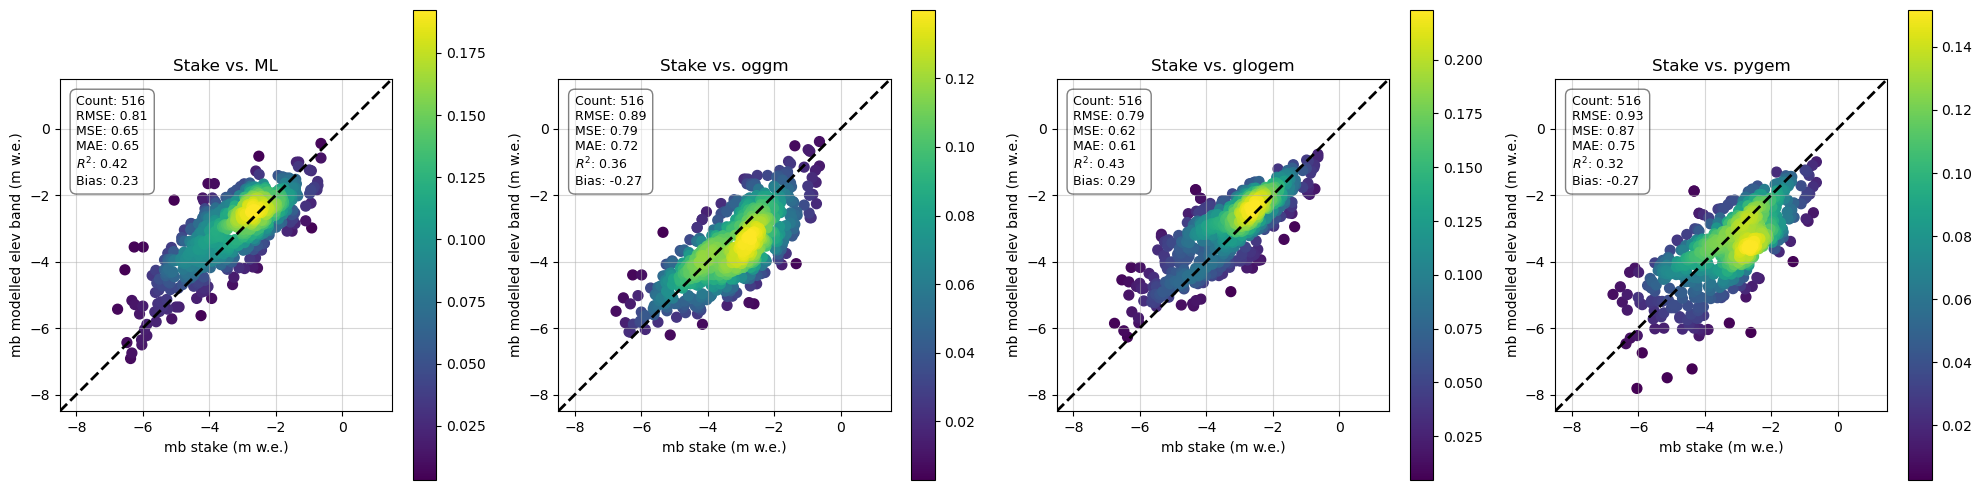

In [55]:
plot_all_models(df_test_summer_nonan, models, 1960, 2020, min_val=-8.5, max_val=1.5)

## Error distributions for point mass balances

In [75]:
# Explore error distribution by BREID, year, and altitude
features_to_explore = ['BREID', 'year', 'altitude']

# Function to group by feature and calculate error statistics
def explore_error_distribution(df, feature):
    grouped = df.groupby(feature).agg({
        'error_ML': ['mean', 'std'],
        'error_oggm': ['mean', 'std'],
        'error_pygem': ['mean', 'std'],
        'error_glogem': ['mean', 'std']
    })
    print(f"\nError distribution grouped by {feature}:")
    print(grouped)

In [76]:
# Function to create box plots
def create_box_plots(df, feature):
    sns.set(style="whitegrid")

    plt.figure(figsize=(14, 8))
    sns.boxplot(x=feature, y='value', hue='variable', 
                data=pd.melt(df, id_vars=[feature], value_vars=['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem']))
    plt.title(f'Error Distribution by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Abs. Error')
    plt.xticks(rotation=90)
    plt.legend(title='Model')
    plt.show()

# Function to create violin plots
def create_violin_plots(df, feature):
    sns.set(style="whitegrid")

    plt.figure(figsize=(12, 8))
    sns.violinplot(x=feature, y='value', hue='variable', 
                   data=pd.melt(df, id_vars=[feature], value_vars=['error_ML', 'error_oggm', 'error_pygem', 'error_glogem']), split=False)
    plt.title(f'Error Distribution by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Error')
    plt.legend(title='Model')
    plt.show()

# Function to create histograms
def create_histograms(df):
    sns.set(style="whitegrid")

    df_melted = pd.melt(df, var_name='Model', value_name='Error', value_vars=['error_ML', 'error_oggm', 'error_pygem', 'error_glogem'])
    plt.figure(figsize=(14, 10))
    sns.histplot(data=df_melted, x='Error', hue='Model', kde=True, element='step')
    plt.title('Error Histogram for Each Model')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

def plot_mean_absolute_error_by_year(df, year_col, error_cols, title='Mean Absolute Error by Year for Each Model'):
    """
    Plots the mean absolute error for each model per year with lines connecting the points.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    year_col (str): Column name for the year data.
    error_cols (list of str): List of column names for the absolute error values.
    title (str): Title of the plot. Default is 'Mean Absolute Error by Year for Each Model'.

    """
    # Calculating mean absolute error per year for each model
    mean_abs_error = df.groupby(year_col)[error_cols].mean().reset_index()

    # Melt the DataFrame to long-format for seaborn
    mean_abs_error_melted = pd.melt(mean_abs_error, id_vars=year_col, value_name='MeanAbsError', var_name='Model')

    # Set up the visualization style
    sns.set(style="whitegrid")

    # Plot mean absolute error for each model by year with lines connecting points
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=mean_abs_error_melted, x=year_col, y='MeanAbsError', hue='Model', marker='o')
    plt.title(title)
    plt.xlabel(year_col.capitalize())
    plt.ylabel('Mean Abs. Error')
    plt.xticks(rotation=90)
    plt.legend(title='Model')
    plt.show()

def plot_error_distribution_by_altitude_interval(df, altitude_col, error_cols, interval=100, title='Error Distribution by Altitude Intervals'):
    """
    Plots the error distribution for altitude intervals as boxplots.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    altitude_col (str): Column name for the altitude data.
    error_cols (list of str): List of column names for the error values.
    interval (int): Interval for binning altitude values. Default is 50.
    title (str): Title of the plot. Default is 'Error Distribution by Altitude Intervals'.
    """
    sns.set(style="whitegrid")

    # Bin the altitude values into intervals
    df['altitude_interval'] = pd.cut(df[altitude_col], bins=range(int(df[altitude_col].min()), int(df[altitude_col].max()) + interval, interval))

    # Melt the DataFrame to long-format for seaborn
    melted_df = pd.melt(df, id_vars=['altitude_interval'], value_vars=error_cols, var_name='Model', value_name='Error')

    # Set up the visualization style
    sns.set(style="whitegrid")

    # Plot error distribution for each altitude interval using boxplots
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='altitude_interval', y='Error', hue='Model', data=melted_df)
    plt.title(title)
    plt.xlabel('Altitude Interval (m)')
    plt.ylabel('Error')
    plt.xticks(rotation=90)
    plt.legend(title='Model')
    plt.show()


### Annual mb, only common points

In [77]:
# Calculate errors for each model
df_test_annual_nonan['error_ML'] = df_test_annual_nonan['mb_ML'] - df_test_annual_nonan['balance']
df_test_annual_nonan['error_oggm'] = df_test_annual_nonan['mb_oggm'] - df_test_annual_nonan['balance']
df_test_annual_nonan['error_pygem'] = df_test_annual_nonan['mb_pygem'] - df_test_annual_nonan['balance']
df_test_annual_nonan['error_glogem'] = df_test_annual_nonan['mb_glogem'] - df_test_annual_nonan['balance']

df_test_annual_nonan['abs_error_ML'] = df_test_annual_nonan['error_ML'].abs()
df_test_annual_nonan['abs_error_oggm'] = df_test_annual_nonan['error_oggm'].abs()
df_test_annual_nonan['abs_error_pygem'] = df_test_annual_nonan['error_pygem'].abs()

df_test_annual_nonan['abs_error_glogem'] = df_test_annual_nonan['error_glogem'].abs()

# Explore distributions for each feature
for feature in features_to_explore:
    explore_error_distribution(df_test_annual_nonan, feature)


Error distribution grouped by BREID:
        error_ML           error_oggm           error_pygem            \
            mean       std       mean       std        mean       std   
BREID                                                                   
54.0    0.052552  1.031396   0.262671  0.620582    0.263940  0.626695   
941.0  -0.121242  0.983496  -0.244419  0.610028    0.007108  0.698715   
1135.0 -0.621946  1.202547   0.000155  0.882140    0.531969  0.973678   
1280.0 -0.676272  0.594880   0.645214  0.770358    0.795955  0.754679   
2085.0  0.889400  0.929511   0.386198  0.849075    1.061762  0.862616   
2478.0  0.383031  0.646541  -0.040393  0.765725    0.313756  0.754238   
2768.0 -0.378720  1.094306   1.022574  0.773898    0.873521  1.235273   
3133.0 -0.274119  0.852107  -1.167754  1.281850   -0.867274  1.312104   
3137.0  0.479256  0.864442  -0.390210  0.685203   -0.125978  0.725154   
3138.0  0.109844  0.602295  -0.937111  0.689059    0.300205  0.730234   
3141.0  0.612

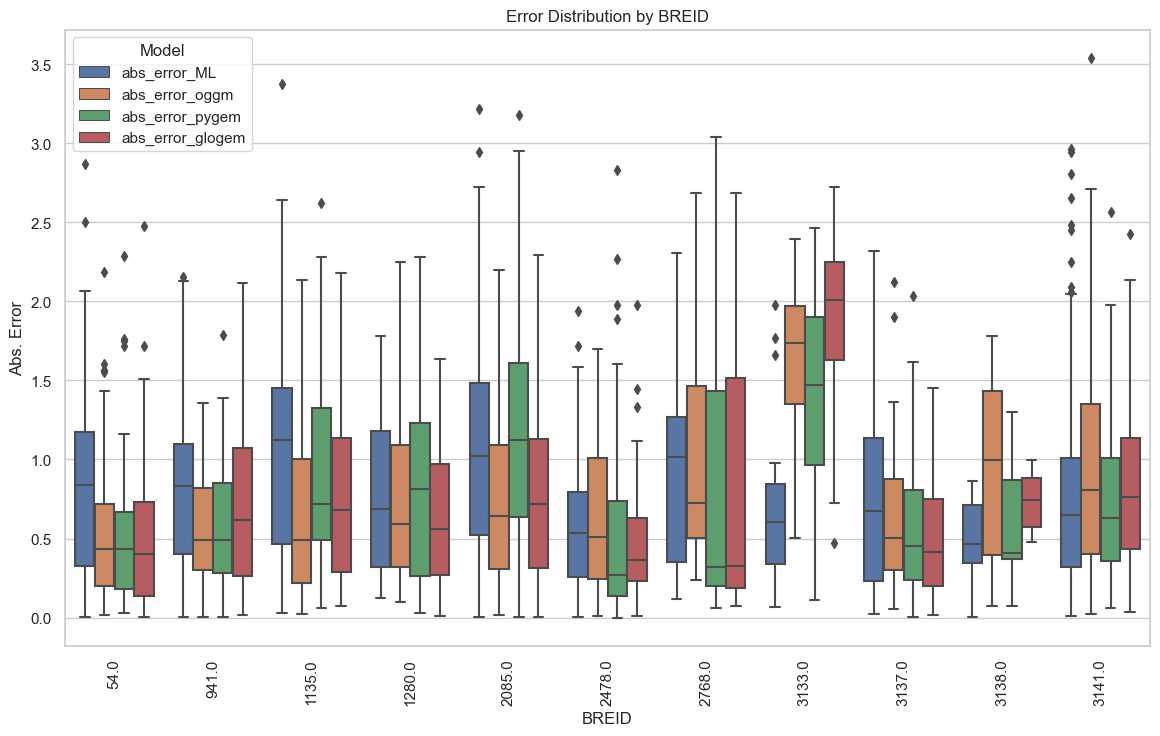

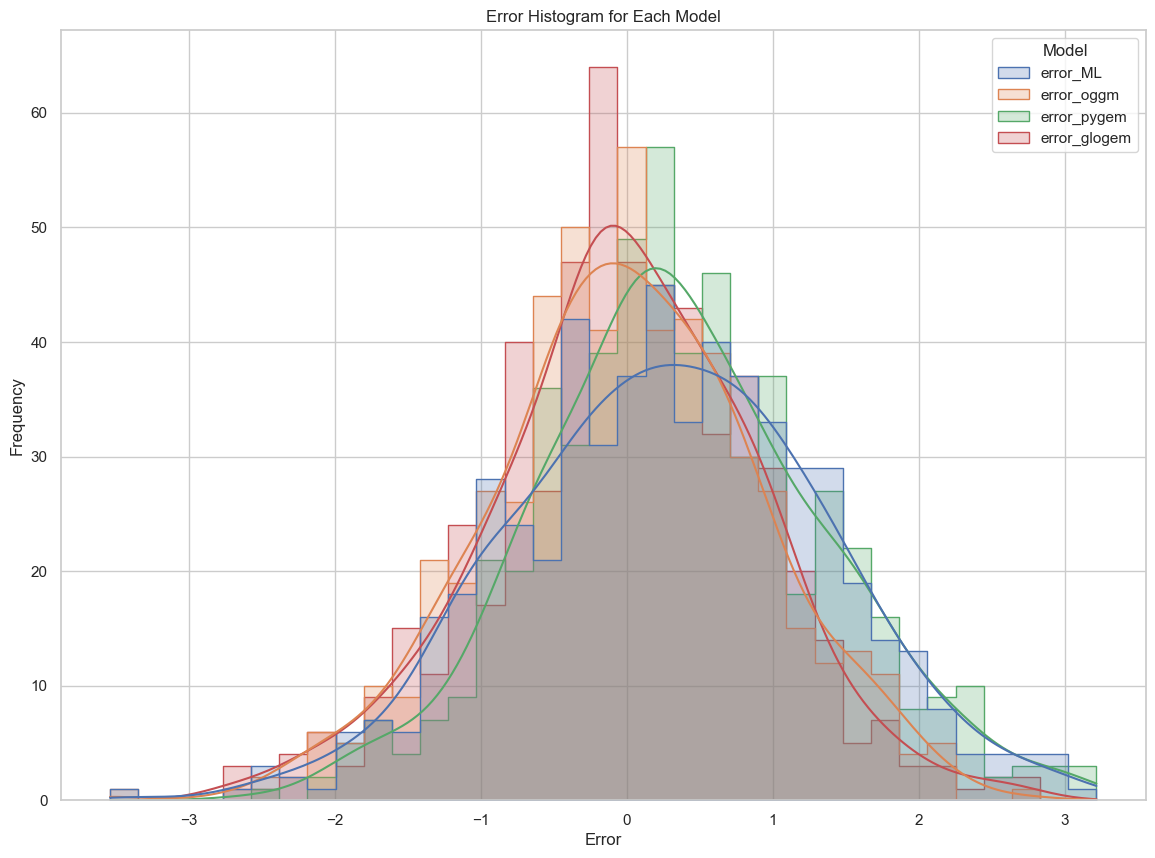

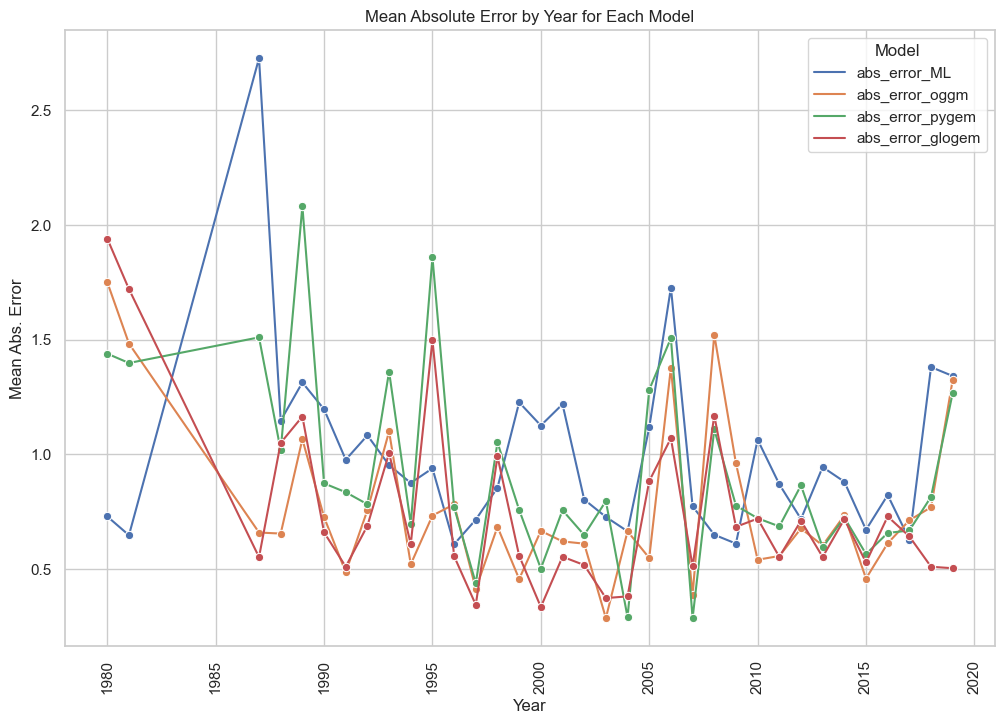

In [78]:
# Annual mass balance, only common points

create_box_plots(df_test_annual_nonan, 'BREID')

create_histograms(df_test_annual_nonan)

plot_mean_absolute_error_by_year(df_test_annual_nonan, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

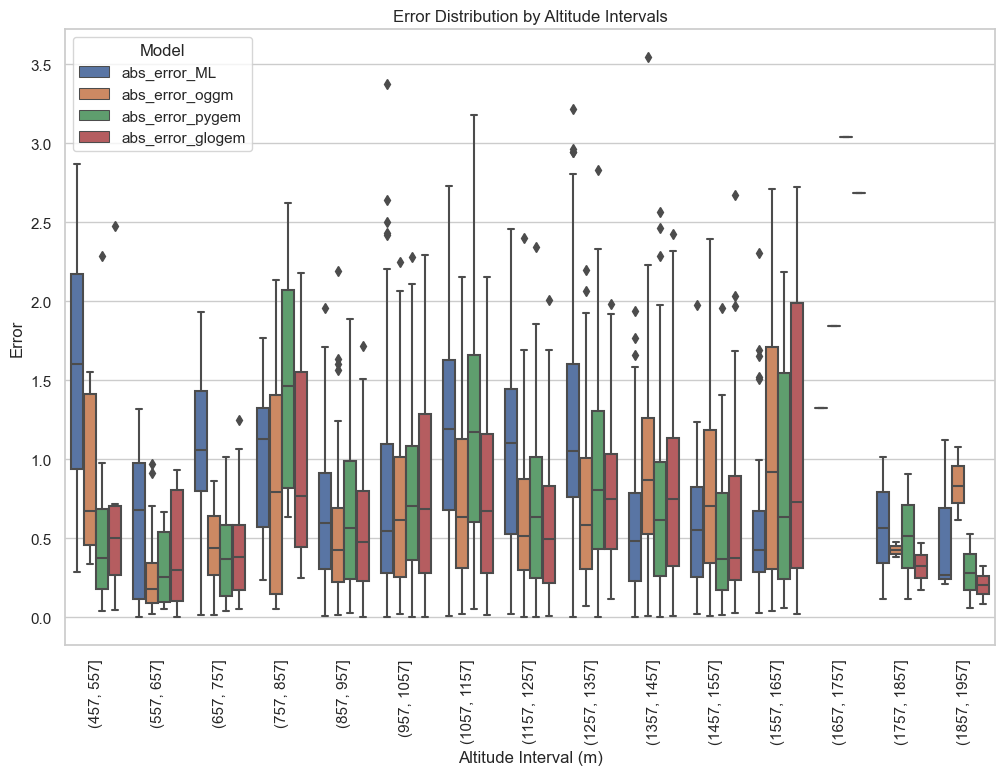

In [65]:
#plot_error_distribution_by_altitude_interval(df_test_annual_nonan, 'altitude', ['error_ML', 'error_oggm', 'error_pygem', 'error_glogem'], interval=100)

plot_error_distribution_by_altitude_interval(df_test_annual_nonan, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)

### Summer mb, only common points

In [66]:
# Calculate errors for each model
df_test_summer_nonan['error_ML'] = df_test_summer_nonan['mb_ML'] - df_test_summer_nonan['balance']
df_test_summer_nonan['error_oggm'] = df_test_summer_nonan['mb_oggm'] - df_test_summer_nonan['balance']
df_test_summer_nonan['error_pygem'] = df_test_summer_nonan['mb_pygem'] - df_test_summer_nonan['balance']
df_test_summer_nonan['error_glogem'] = df_test_summer_nonan['mb_glogem'] - df_test_summer_nonan['balance']

df_test_summer_nonan['abs_error_ML'] = df_test_summer_nonan['error_ML'].abs()
df_test_summer_nonan['abs_error_oggm'] = df_test_summer_nonan['error_oggm'].abs()
df_test_summer_nonan['abs_error_pygem'] = df_test_summer_nonan['error_pygem'].abs()
df_test_summer_nonan['abs_error_glogem'] = df_test_summer_nonan['error_glogem'].abs()

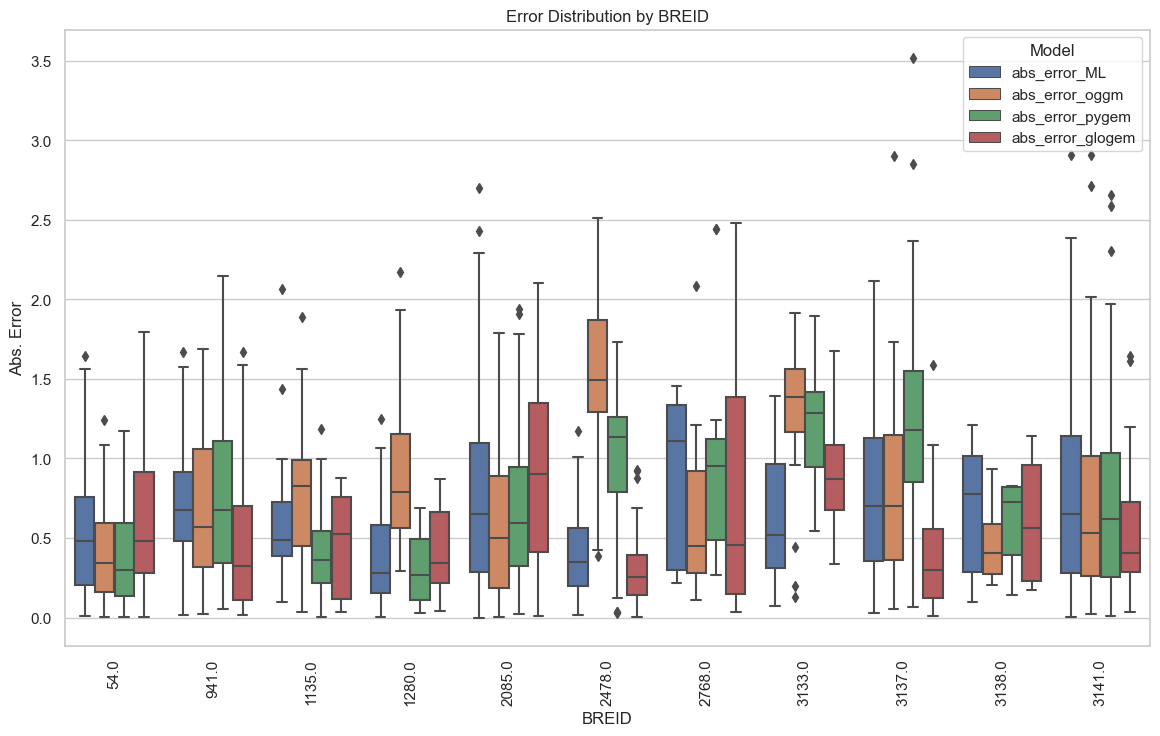

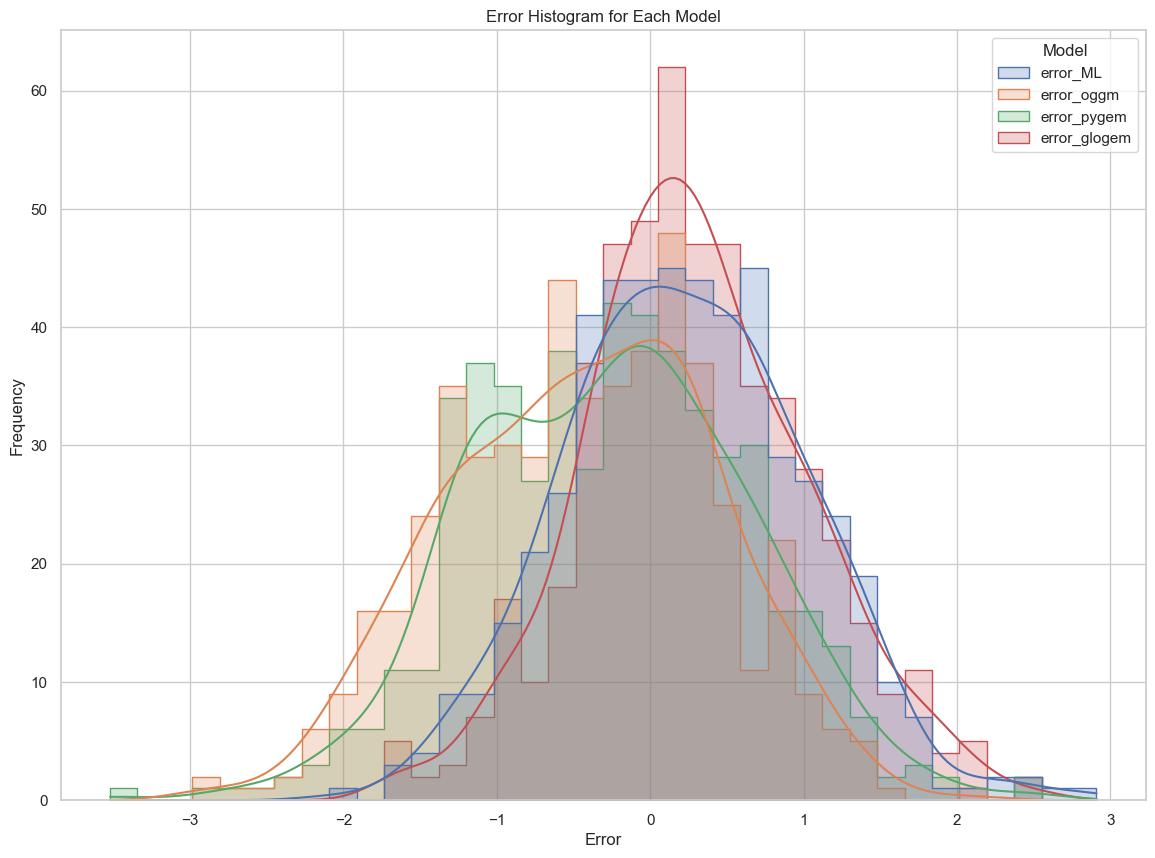

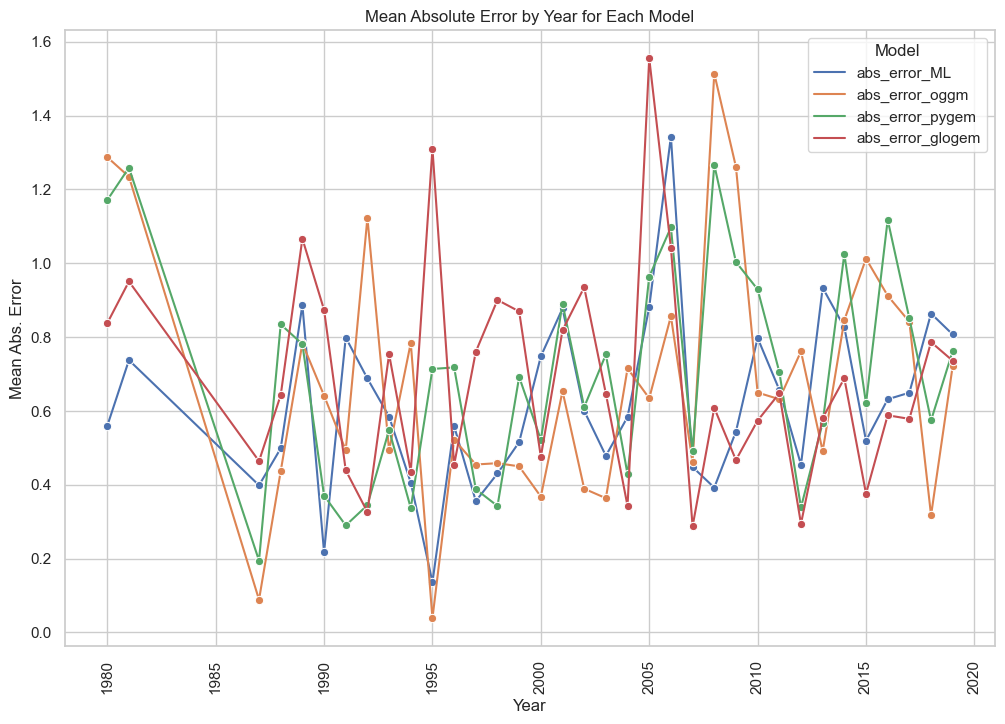

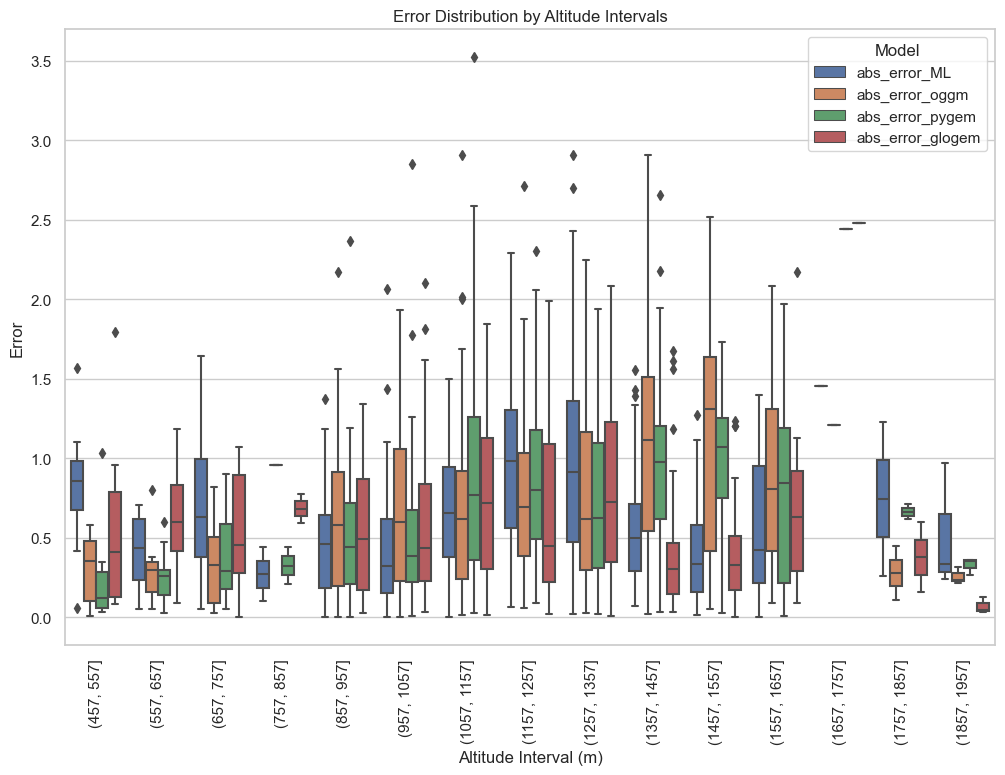

In [67]:
# Summer mass balance, only common points

create_box_plots(df_test_summer_nonan, 'BREID')

create_histograms(df_test_summer_nonan)

plot_mean_absolute_error_by_year(df_test_summer_nonan, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

plot_error_distribution_by_altitude_interval(df_test_summer_nonan, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)

### Winter mb, only common points

In [68]:
# Calculate errors for each model
df_test_winter_nonan['error_ML'] = df_test_winter_nonan['mb_ML'] - df_test_winter_nonan['balance']
df_test_winter_nonan['error_oggm'] = df_test_winter_nonan['mb_oggm'] - df_test_winter_nonan['balance']
df_test_winter_nonan['error_pygem'] = df_test_winter_nonan['mb_pygem'] - df_test_winter_nonan['balance']
df_test_winter_nonan['error_glogem'] = df_test_winter_nonan['mb_glogem'] - df_test_winter_nonan['balance']

df_test_winter_nonan['abs_error_ML'] = df_test_winter_nonan['error_ML'].abs()
df_test_winter_nonan['abs_error_oggm'] = df_test_winter_nonan['error_oggm'].abs()
df_test_winter_nonan['abs_error_pygem'] = df_test_winter_nonan['error_pygem'].abs()
df_test_winter_nonan['abs_error_glogem'] = df_test_winter_nonan['error_glogem'].abs()

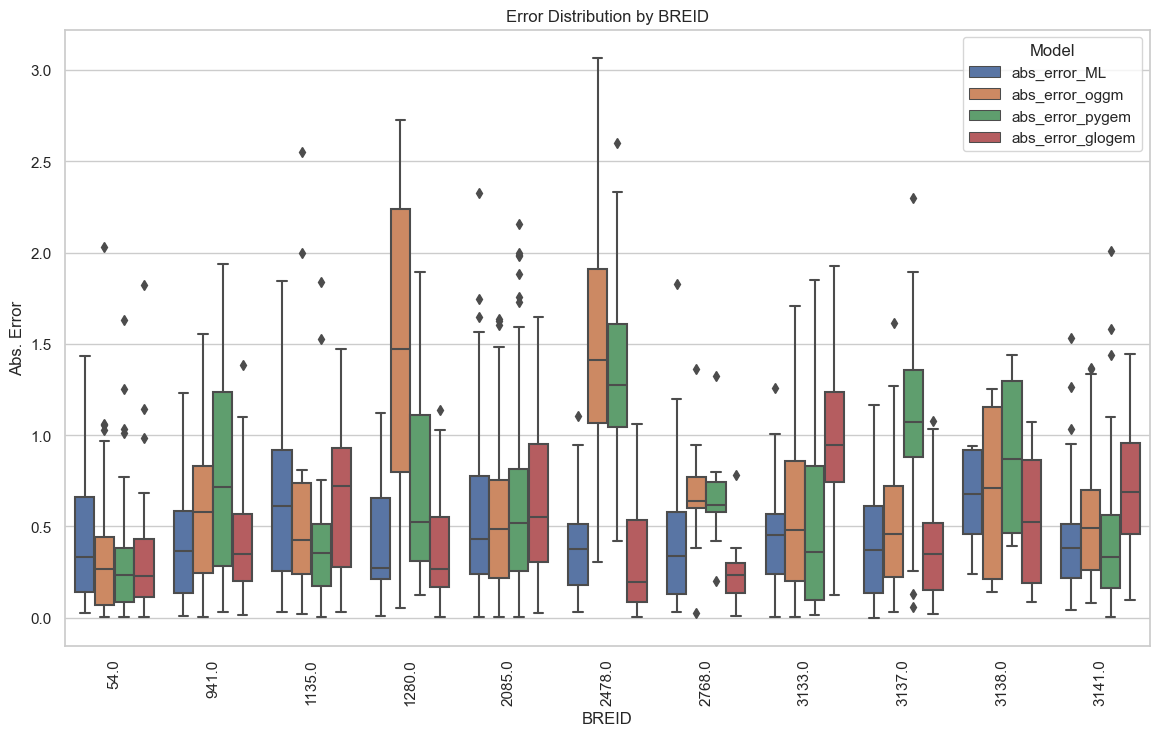

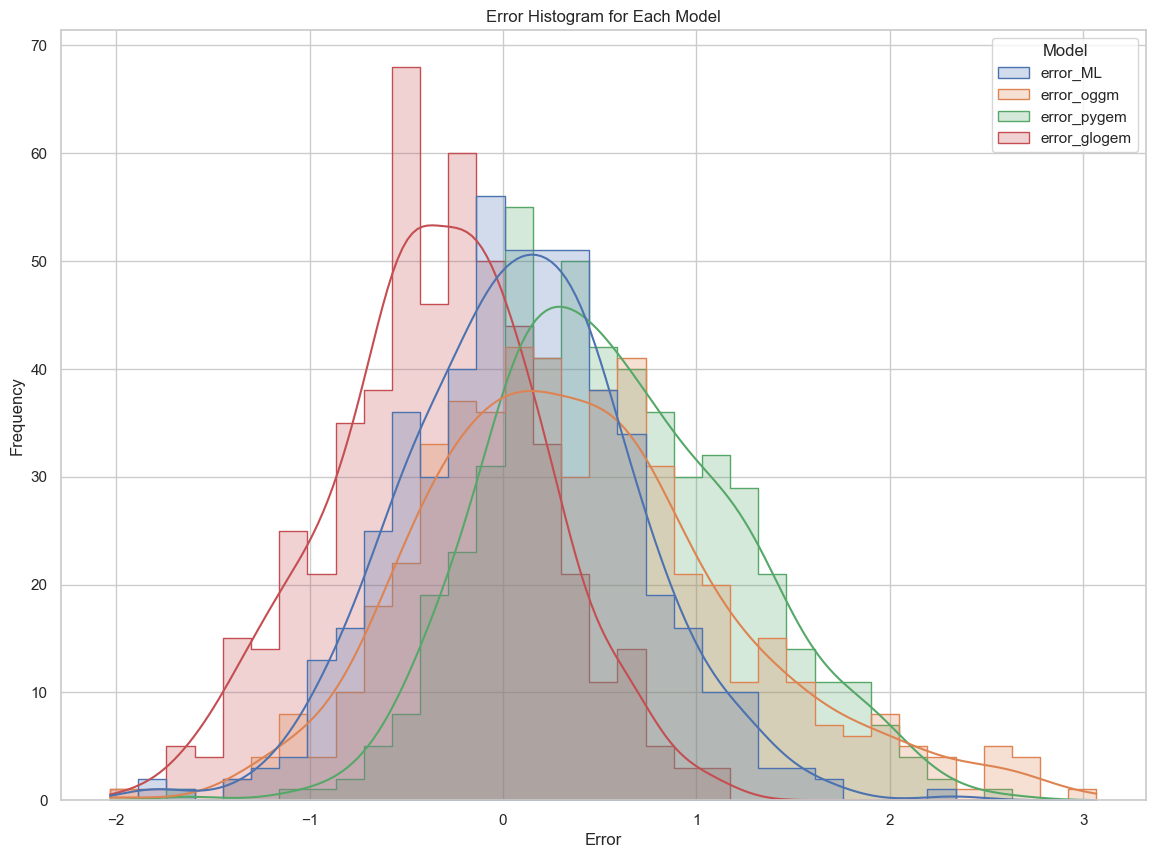

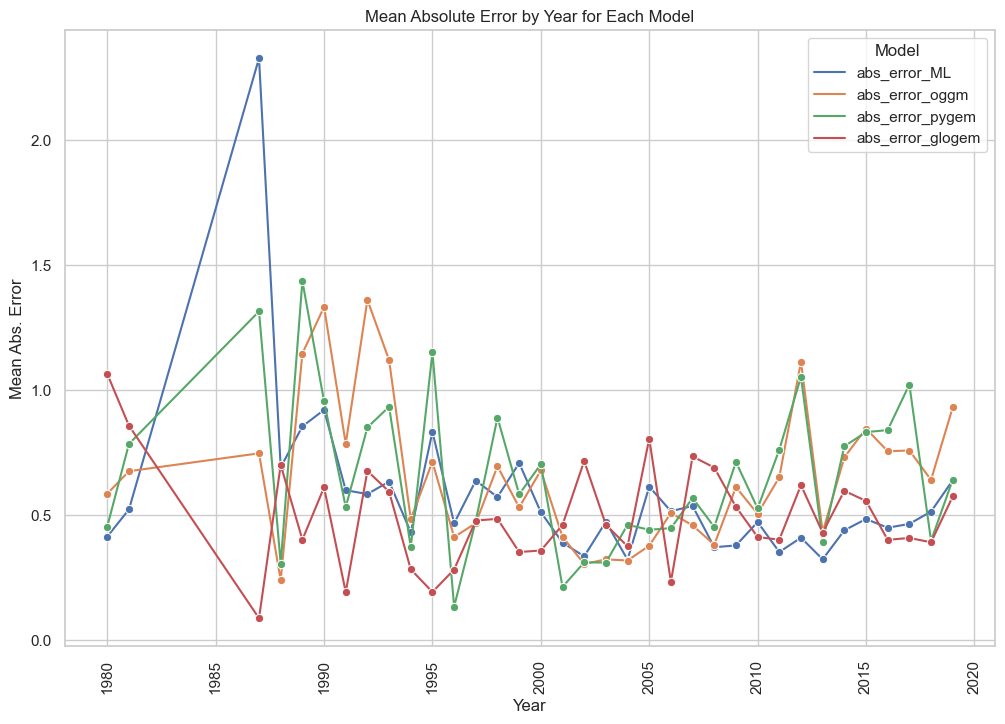

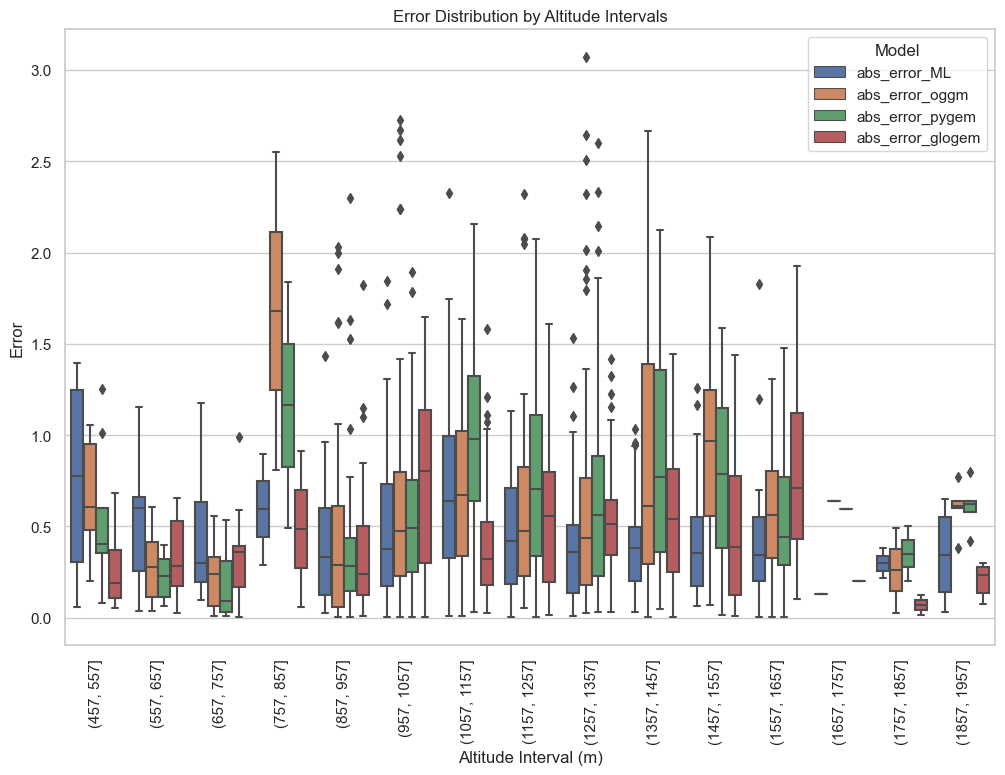

In [69]:
# Winter mass balance, only common points

create_box_plots(df_test_winter_nonan, 'BREID')

create_histograms(df_test_winter_nonan)

plot_mean_absolute_error_by_year(df_test_winter_nonan, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

plot_error_distribution_by_altitude_interval(df_test_winter_nonan, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)

### Annual mb, all points

In [242]:
# Calculate errors for each model
df_test_annual['error_ML'] = df_test_annual['mb_ML'] - df_test_annual['balance']
df_test_annual['error_oggm'] = df_test_annual['mb_oggm'] - df_test_annual['balance']
df_test_annual['error_pygem'] = df_test_annual['mb_pygem'] - df_test_annual['balance']
df_test_annual['error_glogem'] = df_test_annual['mb_glogem'] - df_test_annual['balance']

df_test_annual['abs_error_ML'] = df_test_annual['error_ML'].abs()
df_test_annual['abs_error_oggm'] = df_test_annual['error_oggm'].abs()
df_test_annual['abs_error_pygem'] = df_test_annual['error_pygem'].abs()
df_test_annual['abs_error_glogem'] = df_test_annual['error_glogem'].abs()

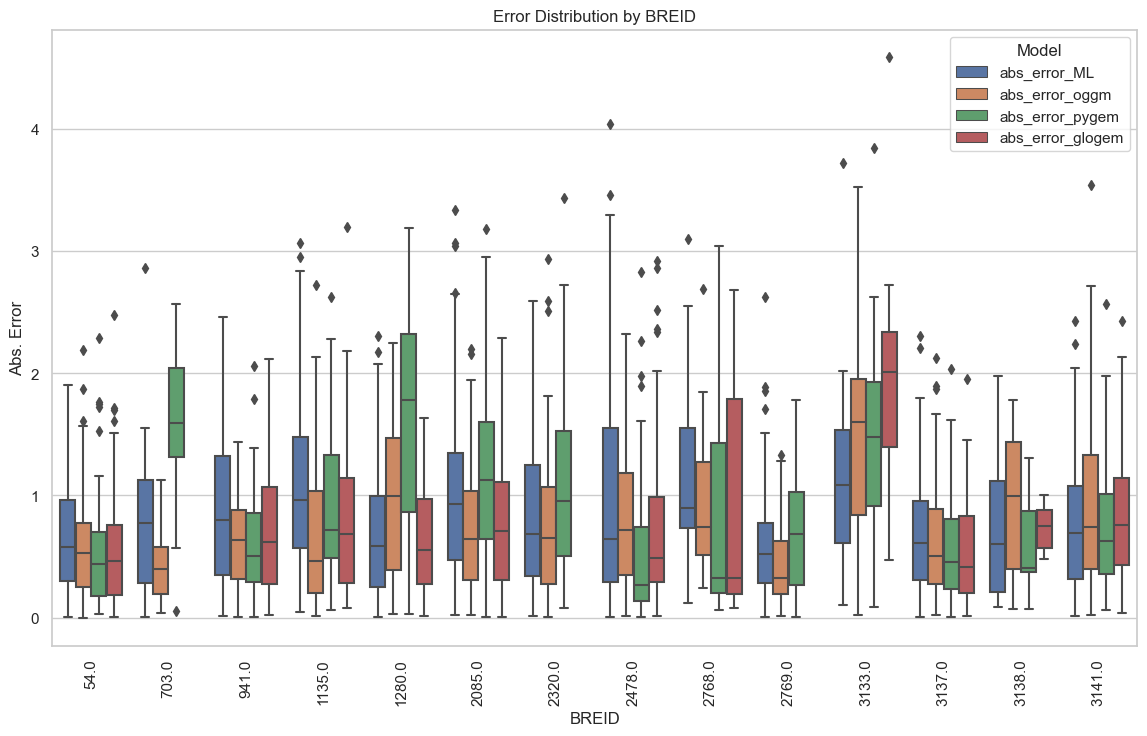

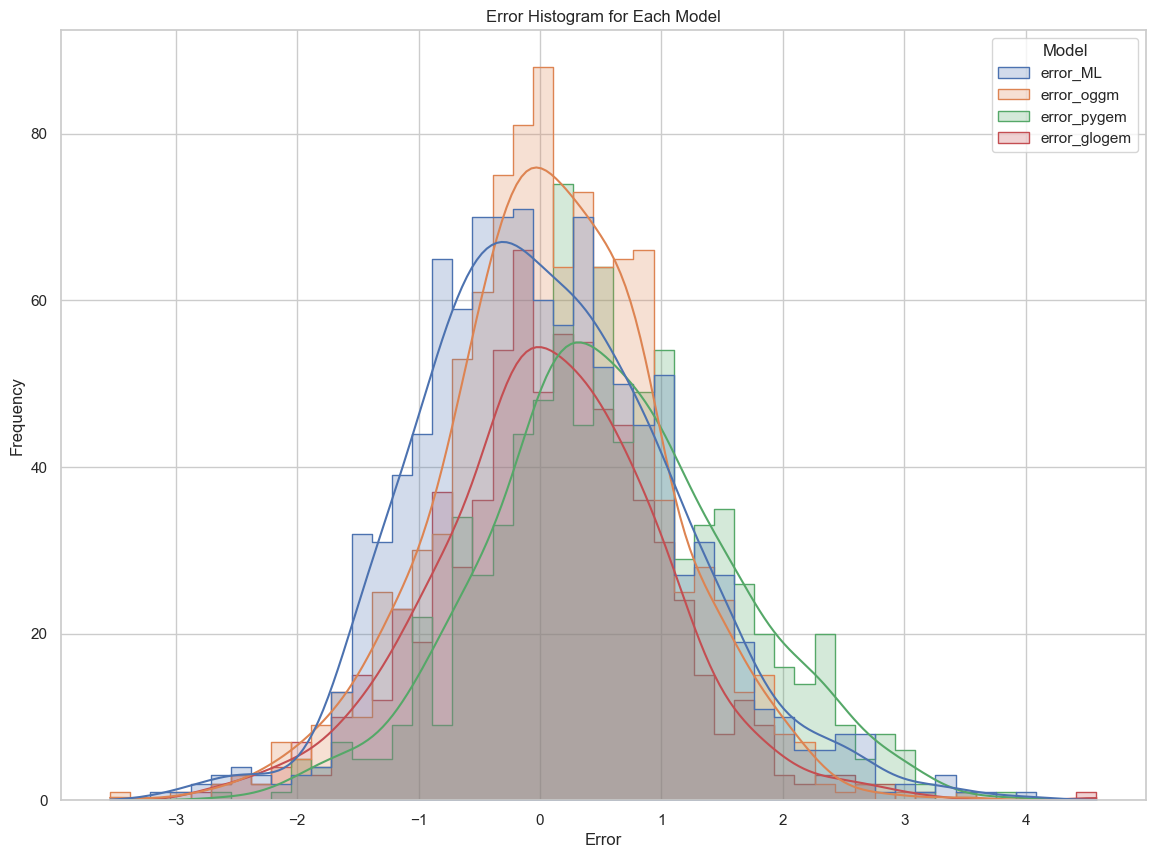

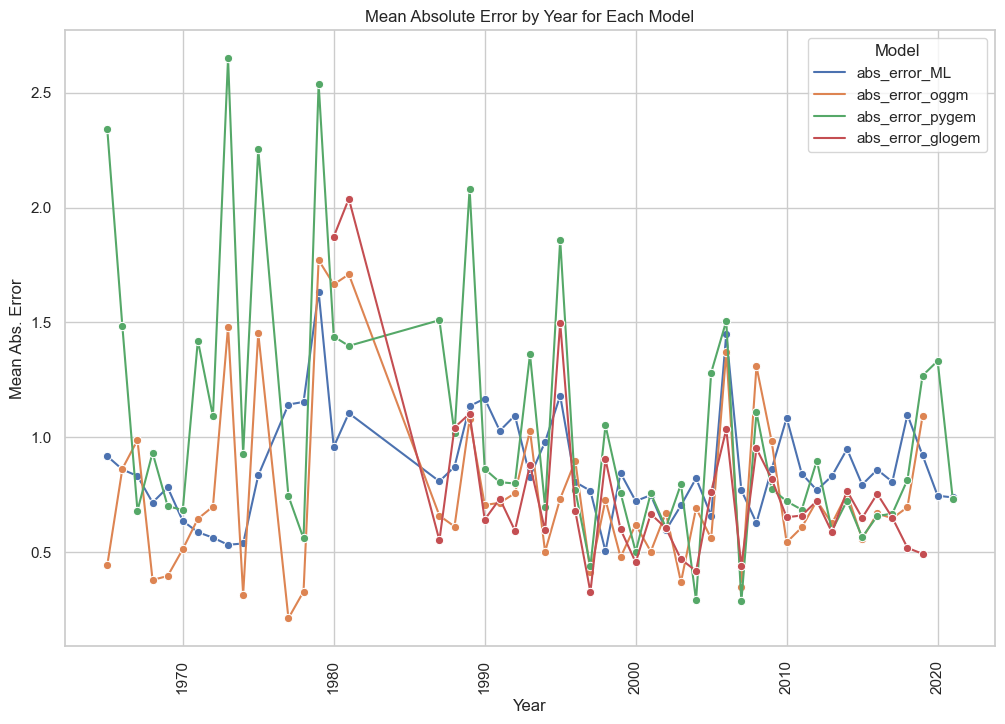

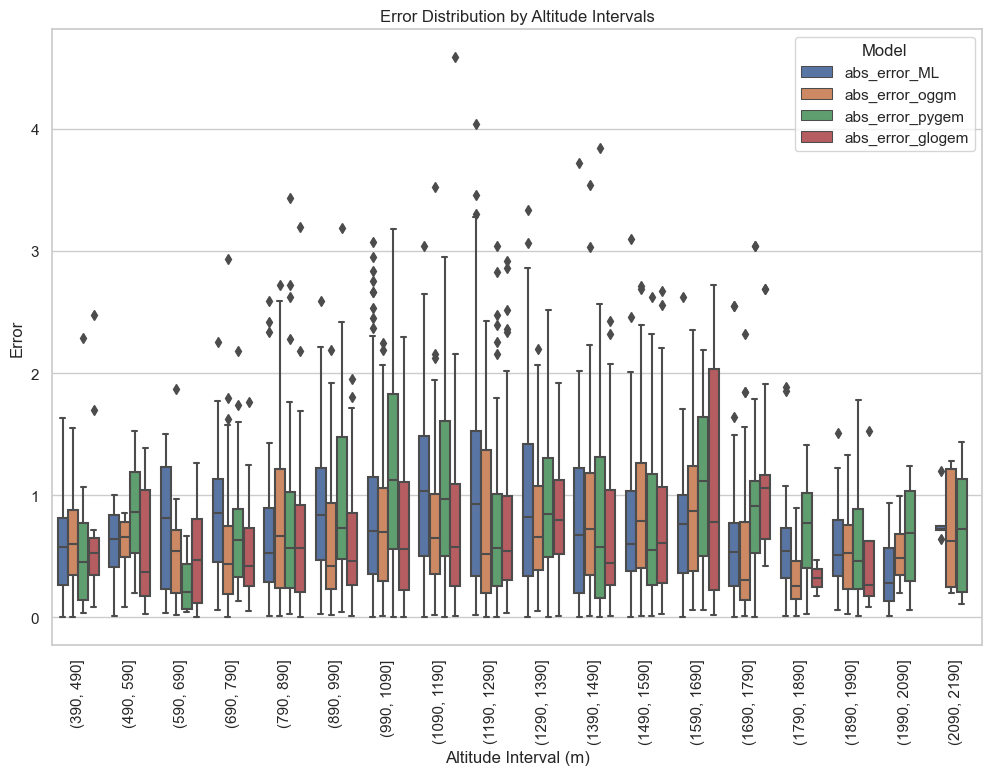

In [243]:
# Annual mass balance, all points

create_box_plots(df_test_annual, 'BREID')

create_histograms(df_test_annual)

plot_mean_absolute_error_by_year(df_test_annual, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

plot_error_distribution_by_altitude_interval(df_test_annual, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)

### Summer mb, all points

In [244]:
# Calculate errors for each model
df_test_summer['error_ML'] = df_test_summer['mb_ML'] - df_test_summer['balance']
df_test_summer['error_oggm'] = df_test_summer['mb_oggm'] - df_test_summer['balance']
df_test_summer['error_pygem'] = df_test_summer['mb_pygem'] - df_test_summer['balance']
df_test_summer['error_glogem'] = df_test_summer['mb_glogem'] - df_test_summer['balance']

df_test_summer['abs_error_ML'] = df_test_summer['error_ML'].abs()
df_test_summer['abs_error_oggm'] = df_test_summer['error_oggm'].abs()
df_test_summer['abs_error_pygem'] = df_test_summer['error_pygem'].abs()
df_test_summer['abs_error_glogem'] = df_test_summer['error_glogem'].abs()

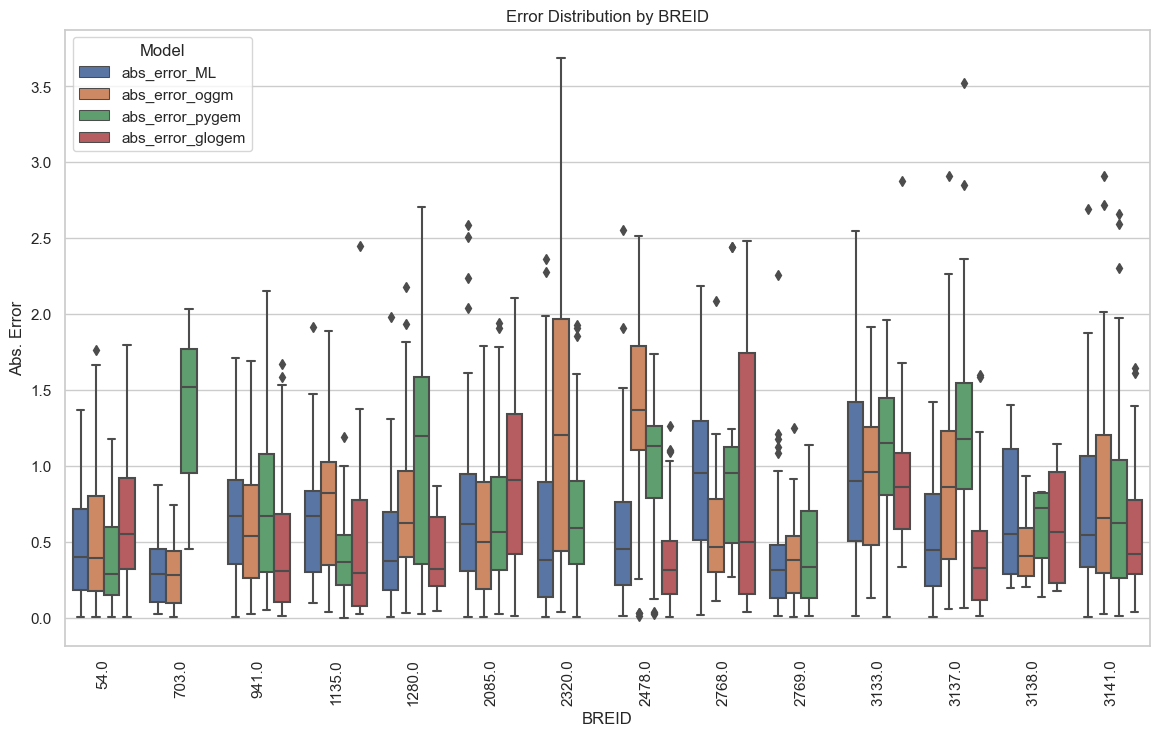

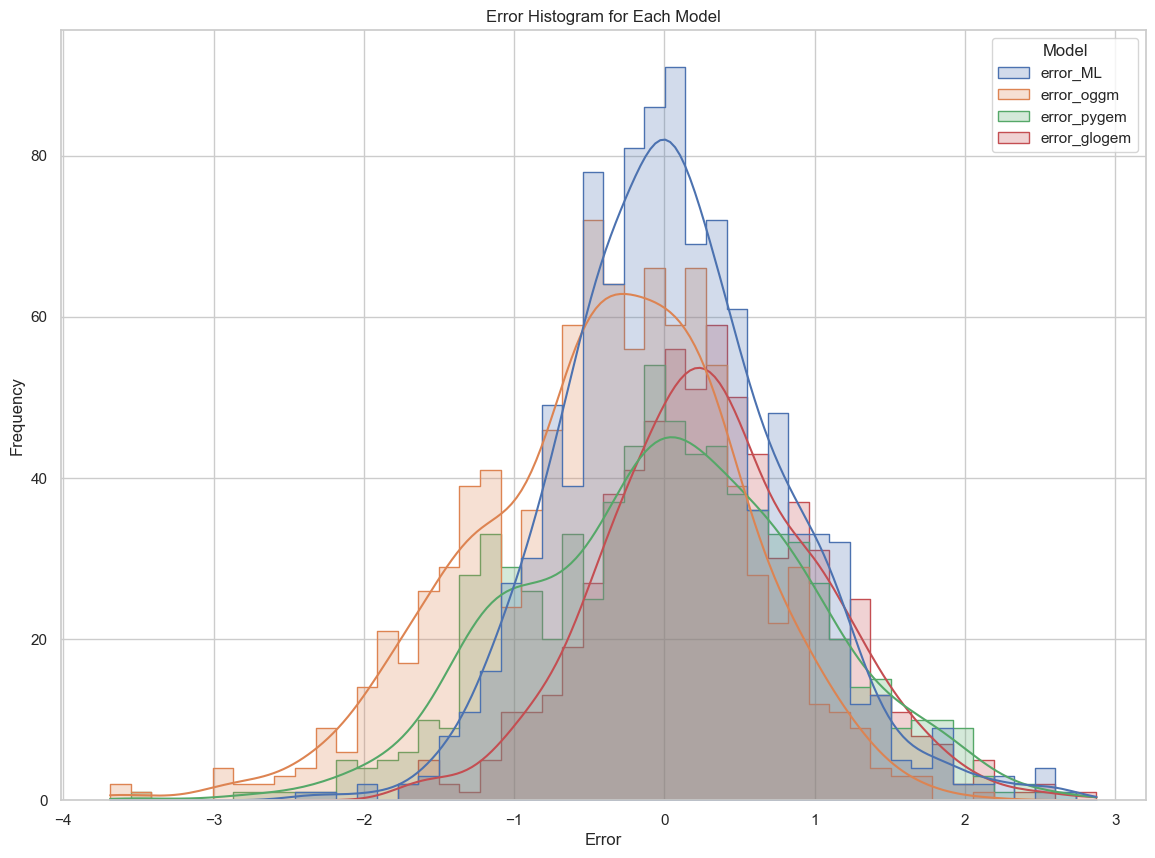

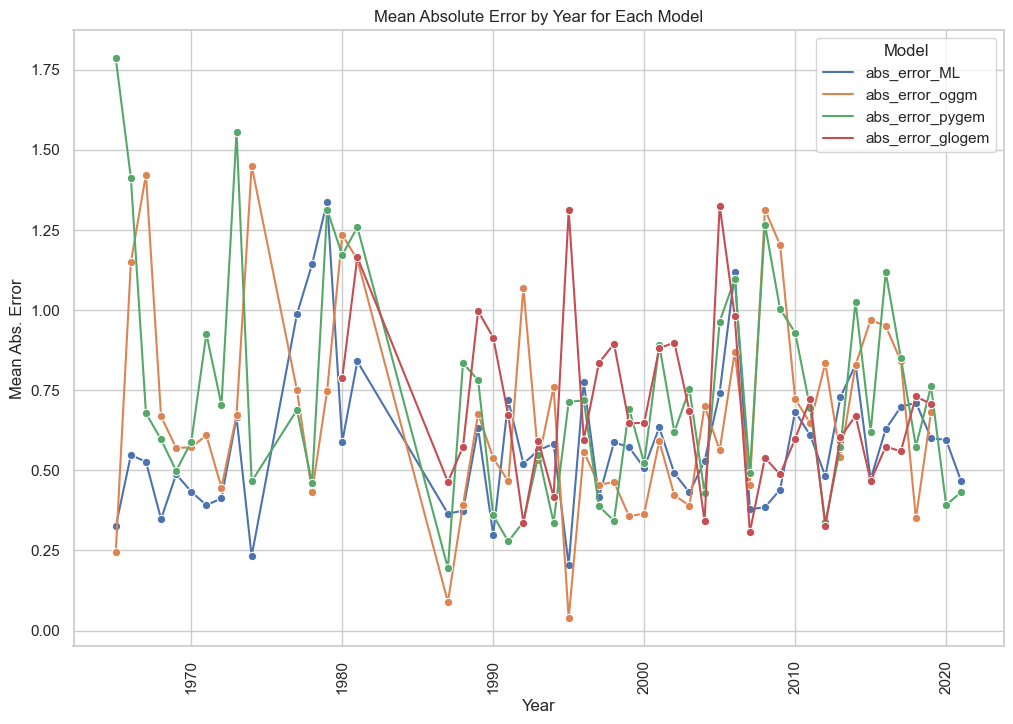

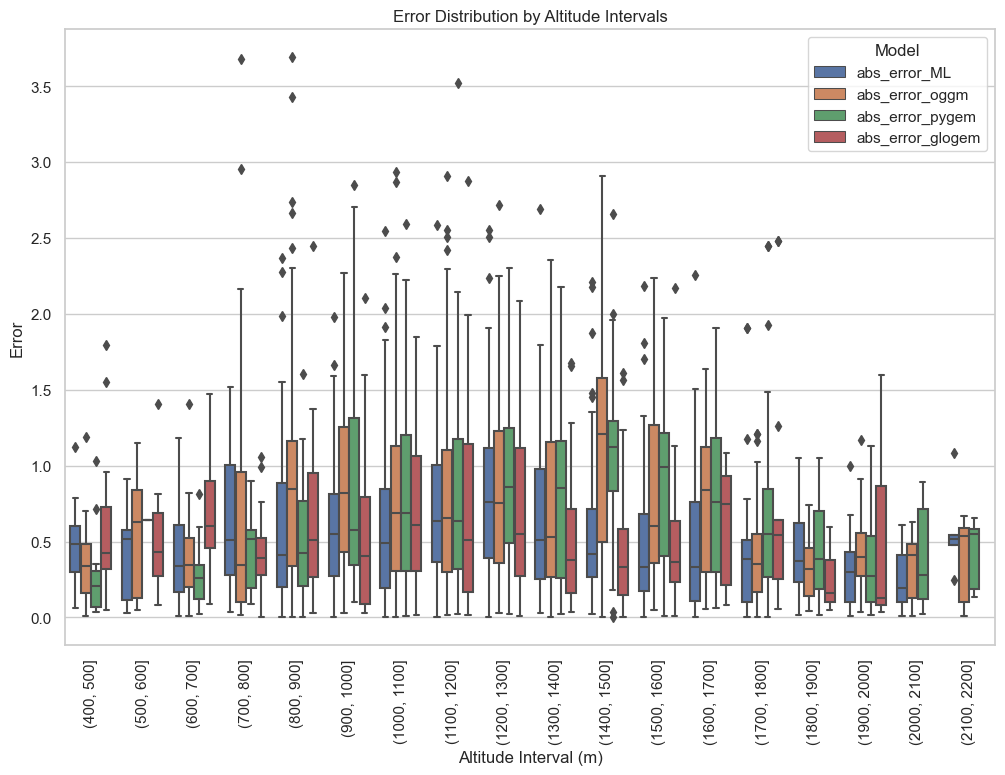

In [245]:
# Summer mass balance, all points

create_box_plots(df_test_summer, 'BREID')

create_histograms(df_test_summer)

plot_mean_absolute_error_by_year(df_test_summer, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

plot_error_distribution_by_altitude_interval(df_test_summer, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)

### Winter mb, all points

In [246]:
#Calculate errors for each model
df_test_winter['error_ML'] = df_test_winter['mb_ML'] - df_test_winter['balance']
df_test_winter['error_oggm'] = df_test_winter['mb_oggm'] - df_test_winter['balance']
df_test_winter['error_pygem'] = df_test_winter['mb_pygem'] - df_test_winter['balance']
df_test_winter['error_glogem'] = df_test_winter['mb_glogem'] - df_test_winter['balance']

df_test_winter['abs_error_ML'] = df_test_winter['error_ML'].abs()
df_test_winter['abs_error_oggm'] = df_test_winter['error_oggm'].abs()
df_test_winter['abs_error_pygem'] = df_test_winter['error_pygem'].abs()
df_test_winter['abs_error_glogem'] = df_test_winter['error_glogem'].abs()

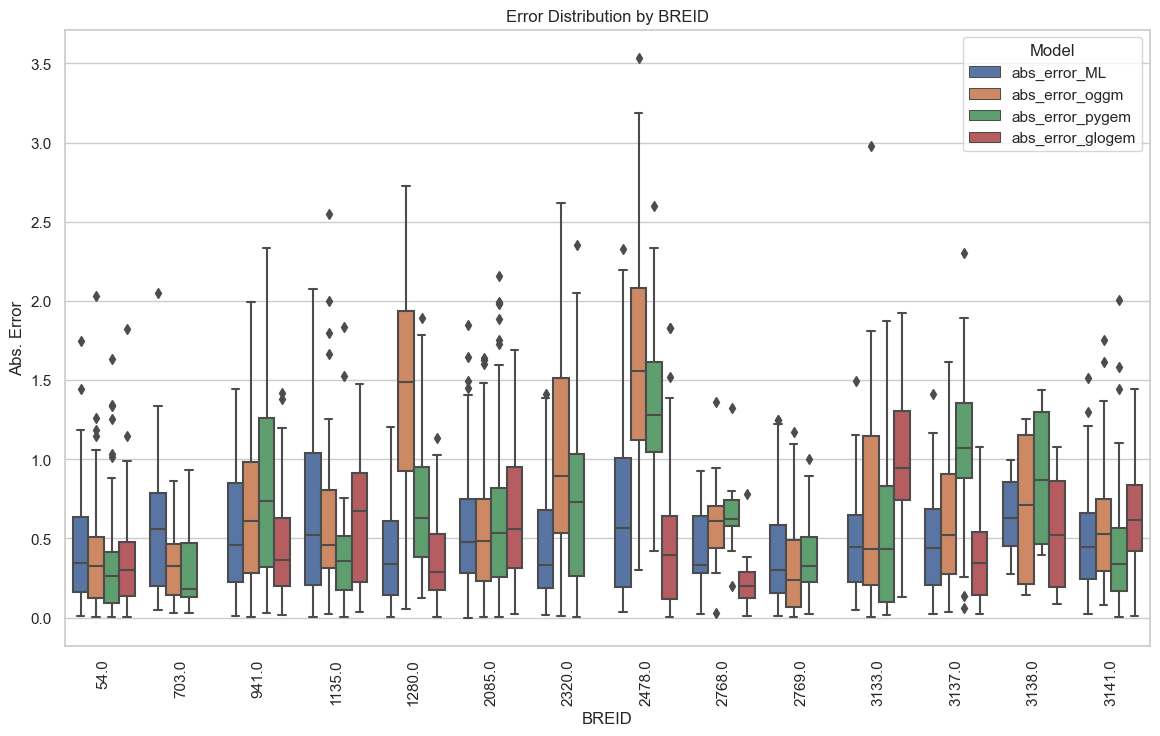

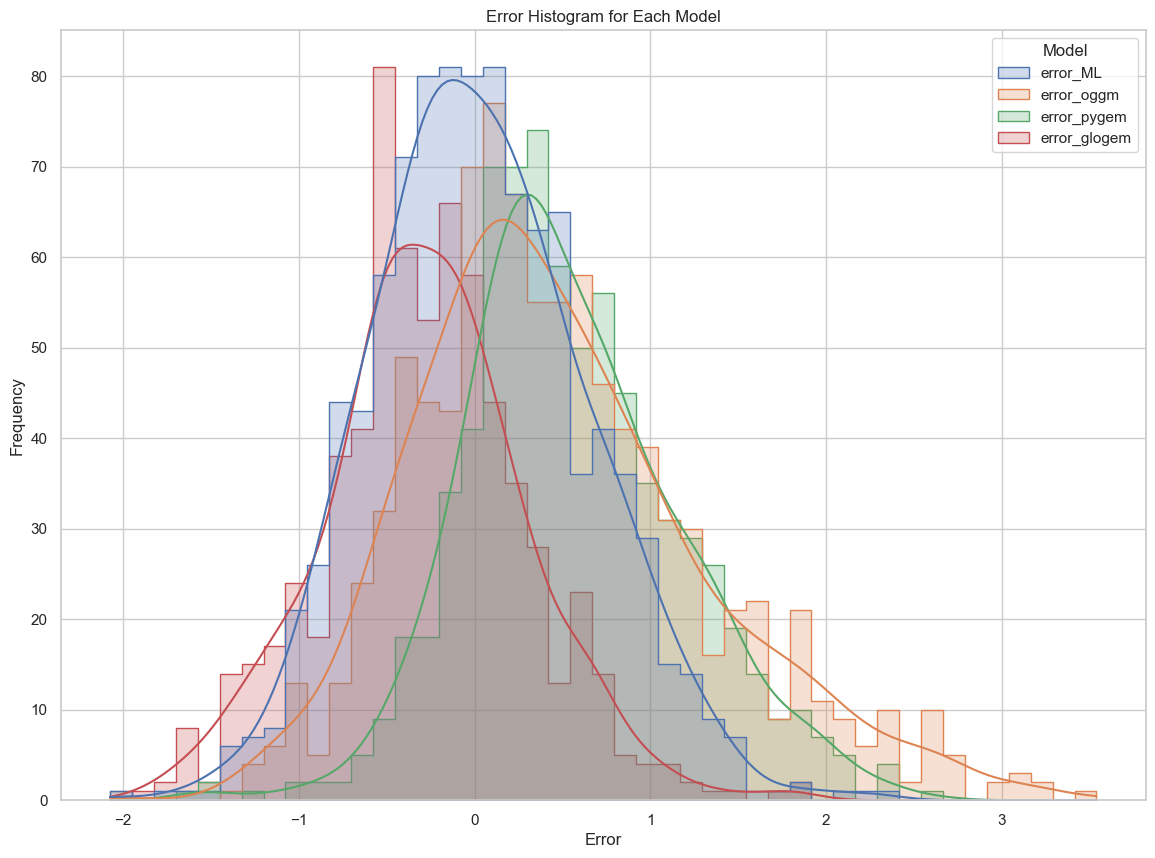

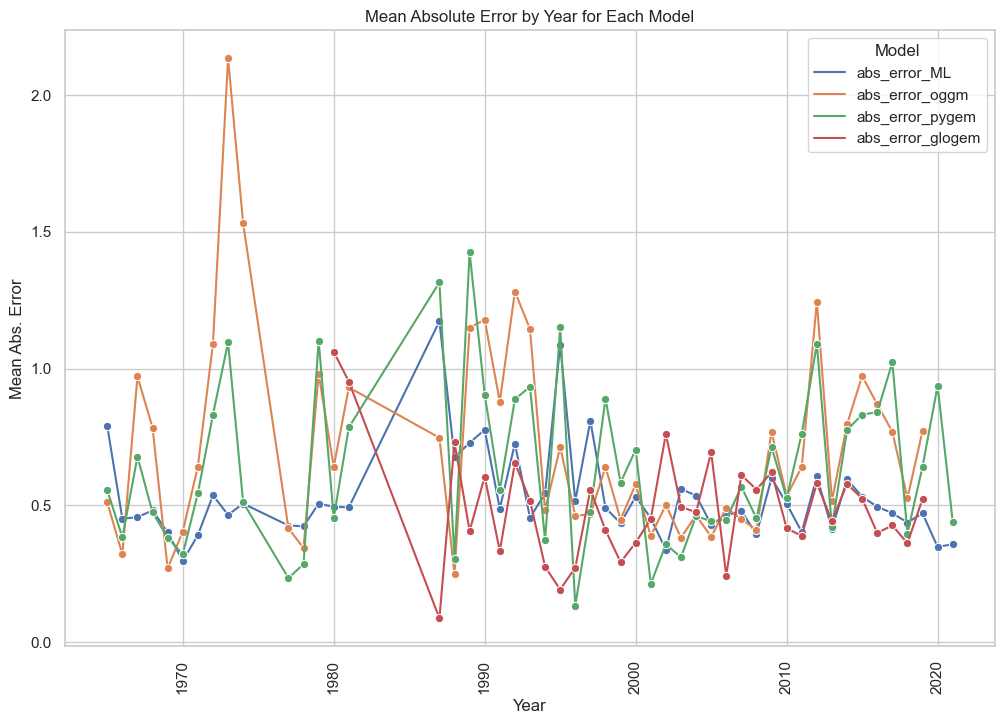

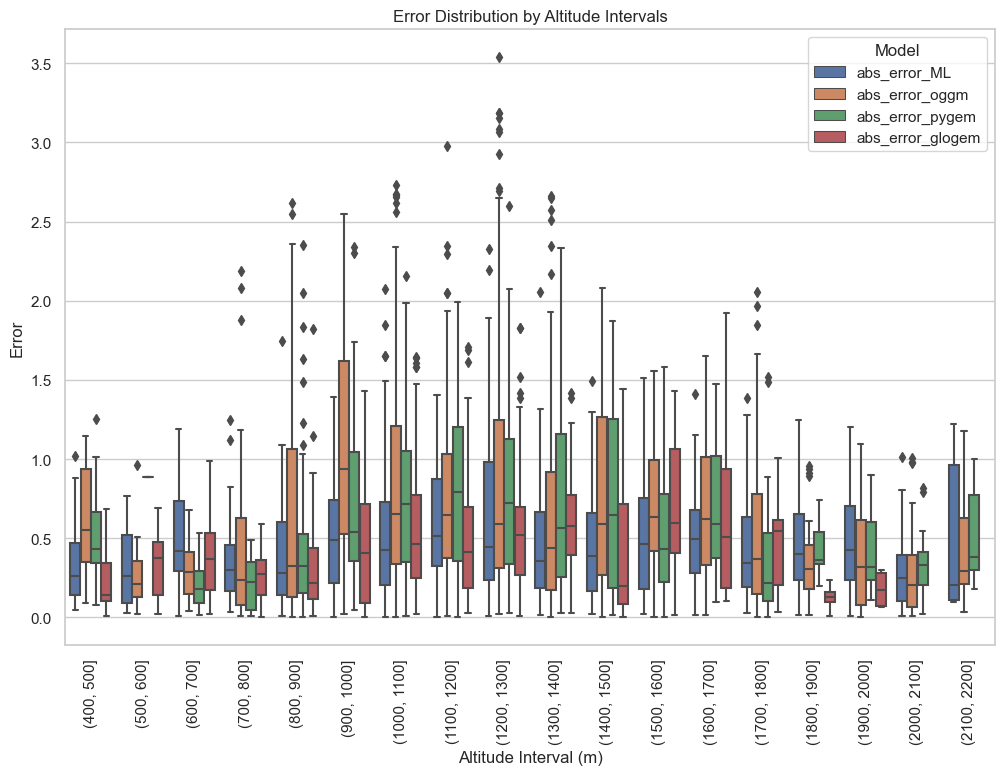

In [247]:
# Winter mass balance, all points

create_box_plots(df_test_winter, 'BREID')

create_histograms(df_test_winter)

plot_mean_absolute_error_by_year(df_test_winter, 'year', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'])

plot_error_distribution_by_altitude_interval(df_test_winter, 'altitude', ['abs_error_ML', 'abs_error_oggm', 'abs_error_pygem', 'abs_error_glogem'], interval=100)